In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

import pingouin as pg
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

%matplotlib inline 

from platform import python_version
print(python_version())

3.8.5


In [2]:
from patsy import dmatrix

In [3]:
ls

Dose_Response_prelim_results.pptx
Fig1.jpg
Fig1a.jpg
FigS1.jpg
FigS2.jpg
FigS3.jpg
FigS4.jpg
First Pass.pptx
GRH Data_Participants_LT18years.xlsx
How the calculator works.docx
Model1_linear.jpg
Model1_linear_uncorrected.jpg
R_mixed_effects.Rmd
R_mixed_effects.nb.html
Seaonal_Var_Dose.jpg
Seaonal_Var_Response.jpg
Stanford VitD Pilot for calculator - De-identifed.xlsx
Stanford_clean.xlsx
TRACT_ZIP_032019.xlsx
Table1_final.docx
Untitled.ipynb
VIDOMA deidentified_VitD dose tool.xlsx
Vidoma_clean.xlsx
age.jpg
deseasonalizing.pptx
final_figures.pptx
model2.jpg
sensitivity_results.xlsx
skeleton_draft.docx
subset_analysis.jpg
table_1.xlsx
temp.jpg
test.csv
vitD PK model in children - manuscript - April 17 2023.docx
vitD PK model in children - manuscript - Dec 21 2022 AD KVH.docx
~$First Pass.pptx
~$table_1.xlsx


In [4]:
colors = ['#1b9e77', '#d95f02', '#7570b3']

In [5]:
correction_size = 5.6 / 2 #3.5

# GRH

In [6]:
df=pd.read_excel('GRH Data_Participants_LT18years.xlsx')

In [7]:
df.shape[0]

664

In [8]:
df.ID.nunique()

424

Text(0.5, 1.0, 'Repeat Measurements: GRH')

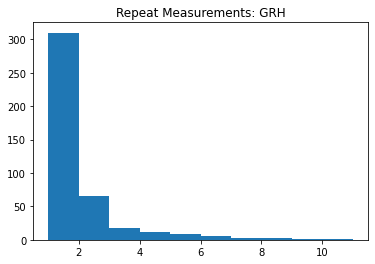

In [9]:
plt.hist(df.groupby('ID').size())
plt.title('Repeat Measurements: GRH')

In [10]:
for col in df.columns:
    df[col] = df[col].mask(df[col] == '.')
    if (col == 'weight_kg') | (col == 'height_current_cm') | (col == 'bmi'):
        df[col] = df[col].astype('float')
df.isna().sum()

ID                            0
Age                           0
state                         0
country                       0
latitude                      0
gender                        0
ethnicity                     0
total_d_dosage                0
weight_kg                    23
height_current_cm            23
bmi                          30
min_outdoors_jan              5
min_outdoors_apr             11
min_outdoors_jul             24
min_outdoors_oct             18
clothing_outdoor_janmar      29
clothing_outdoor_aprjun      29
clothing_outdoor_julsep       0
clothing_outdoor_octdec       0
sunscreen_outdoor_janmar      5
sunscreen_outdoor_aprjun     11
sunscreen_outdoor_julsep     24
sunscreen_outdoor_octdec     18
sunscreen_spf               222
tanning_indoor               13
d_result                      0
d_collect_month               0
count                         0
test_num                      0
dtype: int64

In [11]:
df.groupby('ethnicity').size()

ethnicity
Asian                     9
Black/African             8
Latina/o or Hispanic     34
Other/Mixed              49
White/Caucasian         564
dtype: int64

In [12]:
df.ethnicity.isna().sum()

0

In [13]:
df['dose/kg'] = df.total_d_dosage / df.weight_kg.astype(float)
df.loc[df.total_d_dosage == 0, 'dose/kg'] = 0

(0.0, 500.0)

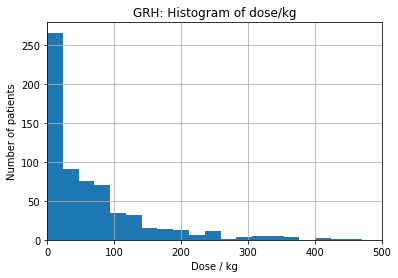

In [14]:
df['dose/kg'].hist(bins=20)
plt.xlabel('Dose / kg')
plt.ylabel('Number of patients')
plt.title('GRH: Histogram of dose/kg')
plt.xlim([0,500])

In [15]:
df['result_corrected'] = df.d_result + correction_size* (- 1 +  np.cos((df.d_collect_month - 2) /6 *3.1415 ))

Text(0.5, 1.0, 'GRH: Histogram of Results')

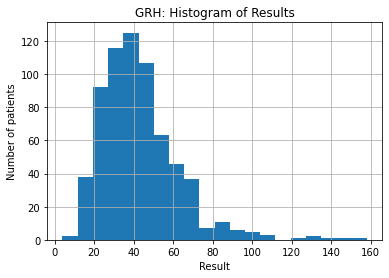

In [16]:
df['d_result'].hist(bins=20)
plt.xlabel('Result')
plt.ylabel('Number of patients')
plt.title('GRH: Histogram of Results')
#plt.xlim([0,500])

Text(0.5, 1.0, 'GRH: Histogram of de-seasonalized')

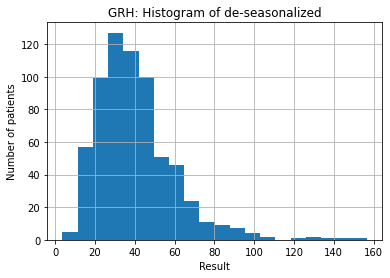

In [17]:
df['result_corrected'].hist(bins=20)
plt.xlabel('Result')
plt.ylabel('Number of patients')
plt.title('GRH: Histogram of de-seasonalized')

(0.0, 165.0)

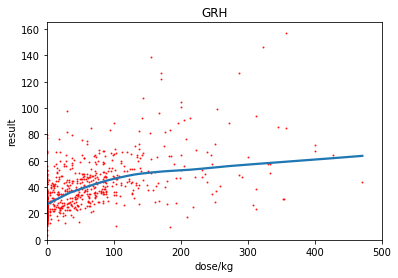

In [18]:
sns.regplot(x='dose/kg', y='result_corrected', data=df, lowess=True, scatter_kws={'color':'r', 's':1})
plt.ylabel('result')
plt.title('GRH')
plt.xlim([0,500])
plt.ylim([0,165])

In [19]:
df['visit_count'] = df.sort_values(by = 'Age',ascending=True).groupby('ID').cumcount()

In [20]:
df.columns

Index(['ID', 'Age', 'state', 'country', 'latitude', 'gender', 'ethnicity',
       'total_d_dosage', 'weight_kg', 'height_current_cm', 'bmi',
       'min_outdoors_jan', 'min_outdoors_apr', 'min_outdoors_jul',
       'min_outdoors_oct', 'clothing_outdoor_janmar',
       'clothing_outdoor_aprjun', 'clothing_outdoor_julsep',
       'clothing_outdoor_octdec', 'sunscreen_outdoor_janmar',
       'sunscreen_outdoor_aprjun', 'sunscreen_outdoor_julsep',
       'sunscreen_outdoor_octdec', 'sunscreen_spf', 'tanning_indoor',
       'd_result', 'd_collect_month', 'count', 'test_num', 'dose/kg',
       'result_corrected', 'visit_count'],
      dtype='object')

In [21]:
0.632444*12

7.589328

In [22]:
df_temp = pd.merge(df[['ID', 'gender', 'dose/kg', 'd_result', 'result_corrected', 'visit_count', 'Age']], df[['ID', 'dose/kg', 'd_result', 'result_corrected', 'visit_count', 'Age', 'weight_kg', 'height_current_cm']], on='ID')
df_temp = df_temp[df_temp.visit_count_y - df_temp.visit_count_x == 1]
df_temp['change in dose/kg'] = df_temp['dose/kg_y'] - df_temp['dose/kg_x']
df_temp['change in result'] = df_temp['d_result_y'] - df_temp['d_result_x']
df_temp['change_result_corrected'] = df_temp['result_corrected_y'] - df_temp['result_corrected_x']
df_temp['change in age'] = df_temp['Age_y'] - df_temp['Age_x']

In [23]:
df.columns

Index(['ID', 'Age', 'state', 'country', 'latitude', 'gender', 'ethnicity',
       'total_d_dosage', 'weight_kg', 'height_current_cm', 'bmi',
       'min_outdoors_jan', 'min_outdoors_apr', 'min_outdoors_jul',
       'min_outdoors_oct', 'clothing_outdoor_janmar',
       'clothing_outdoor_aprjun', 'clothing_outdoor_julsep',
       'clothing_outdoor_octdec', 'sunscreen_outdoor_janmar',
       'sunscreen_outdoor_aprjun', 'sunscreen_outdoor_julsep',
       'sunscreen_outdoor_octdec', 'sunscreen_spf', 'tanning_indoor',
       'd_result', 'd_collect_month', 'count', 'test_num', 'dose/kg',
       'result_corrected', 'visit_count'],
      dtype='object')

In [24]:
df.d_collect_month

0       1
1       2
2       7
3      10
4      10
       ..
659    11
660     5
661    11
662     5
663    11
Name: d_collect_month, Length: 664, dtype: int64

In [25]:
df[df.ID.isin(set(df[df.weight_kg.isna()].ID)) & (df['count'] >= 2)][['ID', 'weight_kg', 'height_current_cm', 'Age', 'gender', 'count', 'test_num']].sort_values(by=['ID', 'test_num'])

,ID,weight_kg,height_current_cm,Age,gender,count,test_num


In [26]:
# code to infer missing heights and weights

from pygrowup import Calculator
calculator = Calculator(adjust_height_data=False, adjust_weight_scores=False,
                       include_cdc=True, logger_name='pygrowup',
                       log_level='INFO')

weight_at_baseline = 26
height_at_baseline = 130
age_at_baseline = 10.105407
gender = 'M'

age_at_missing = 5.656400


#find weight
z_baseline= calculator.wfa(weight_at_baseline, age_at_baseline * 12, gender)

df_ans = pd.DataFrame(columns = ['shift', 'new_z'])
zz = 0
for ss in range(0,1000):
    shift = (ss-500)/10
    if weight_at_baseline + shift > 0:
        df_ans.loc[zz] = [shift, z_baseline - calculator.wfa(weight_at_baseline + shift, age_at_missing * 12, gender)]
        zz += 1
df_ans['zsquared'] = df_ans.new_z**2
df_ans['zsquared'] = df_ans.zsquared.astype(float)
weight_at_missing = weight_at_baseline + df_ans.loc[df_ans.zsquared.idxmin(), 'shift']


#find height
z_baseline= calculator.lhfa(height_at_baseline, age_at_baseline * 12, gender)

df_ans = pd.DataFrame(columns = ['shift', 'new_z'])
zz = 0
for ss in range(0,1000):
    shift = (ss-500)/5
    if height_at_baseline + shift > 0:
        df_ans.loc[zz] = [shift, z_baseline - calculator.lhfa(height_at_baseline + shift, age_at_missing * 12, gender)]
        zz += 1
df_ans['zsquared'] = df_ans.new_z**2
df_ans['zsquared'] = df_ans.zsquared.astype(float)
height_at_missing = height_at_baseline + df_ans.loc[df_ans.zsquared.idxmin(), 'shift']


In [27]:
weight_at_missing

16.7

In [28]:
height_at_missing

106.0

In [29]:
df_temp.columns

Index(['ID', 'gender', 'dose/kg_x', 'd_result_x', 'result_corrected_x',
       'visit_count_x', 'Age_x', 'dose/kg_y', 'd_result_y',
       'result_corrected_y', 'visit_count_y', 'Age_y', 'weight_kg',
       'height_current_cm', 'change in dose/kg', 'change in result',
       'change_result_corrected', 'change in age'],
      dtype='object')

In [26]:
#df1_change = df_temp[(df_temp['dose/kg_x'] == 0) & (df_temp['change in dose/kg'] > 0) & (df_temp['change in age'] > 1/12) & (df_temp['change in age'] < 12/12)][['d_result_x', 'change in dose/kg', 'd_result_y', 'change in result', 'Age_y']].copy()
df1_change = df_temp[(df_temp['change in age'] > 1/12) 
                     & (df_temp['change in age'] <= 9/12)][['ID',
                                                            'gender',
                                                            'd_result_x',
                                                            'result_corrected_x',
                                                            'dose/kg_x', 
                                                            'd_result_y',
                                                            'result_corrected_y',
                                                            'dose/kg_y', 
                                                            'change in result', 
                                                            'change_result_corrected',
                                                            'change in dose/kg',
                                                            'Age_y', 
                                                            'weight_kg', 
                                                            'height_current_cm']].rename(columns={'d_result_x': 'result_baseline',
                                                            'result_corrected_x': 'result_baseline_corrected',
                                                            'dose/kg_x': 'dose_baseline', 
                                                            'd_result_y': 'result',
                                                            'result_corrected_y': 'result_corrected',
                                                            'dose/kg_y': 'dose', 
                                                            'change in result': 'change_result', 
                                                            'change in dose/kg': 'change_dose',
                                                            'Age_y': 'age', 
                                                            'weight_kg': 'weight', 
                                                            'height_current_cm': 'height'}).copy()
df1=df.copy()

Text(0, 0.5, 'number of GRH patients')

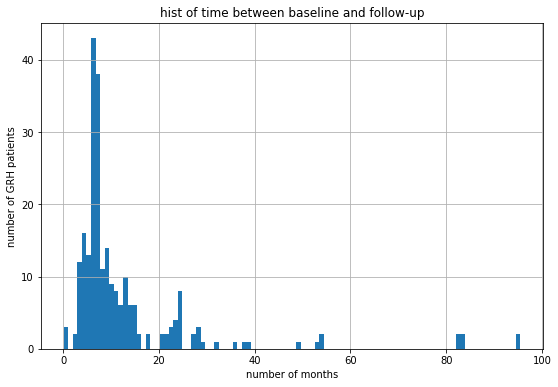

In [27]:
plt.figure(figsize=(9,6))
#(df_temp[(df_temp['dose/kg_x'] == 0) & (df_temp['change in dose/kg'] > 0) ]['change in age']* 12).hist(bins=100)
(df_temp['change in age']* 12).hist(bins=100)
plt.title('hist of time between baseline and follow-up')
plt.xlabel('number of months')
plt.ylabel('number of GRH patients')

(-125.0, 125.0)

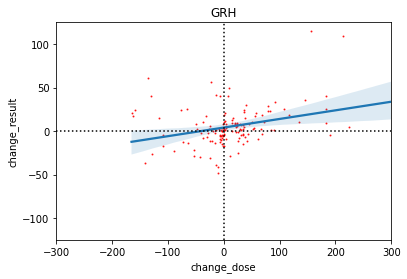

In [28]:
sns.regplot(x='change_dose', y='change_result', data=df1_change, scatter_kws={'color':'r', 's':1}, ci=95, fit_reg = True)
plt.title('GRH')
plt.axvline(0, color = 'k', linestyle=':')
plt.axhline(0, color = 'k', linestyle=':')
plt.xlim([-300,300])
plt.ylim([-125, 125])

Text(0.5, 1.0, 'Result by collection Month')

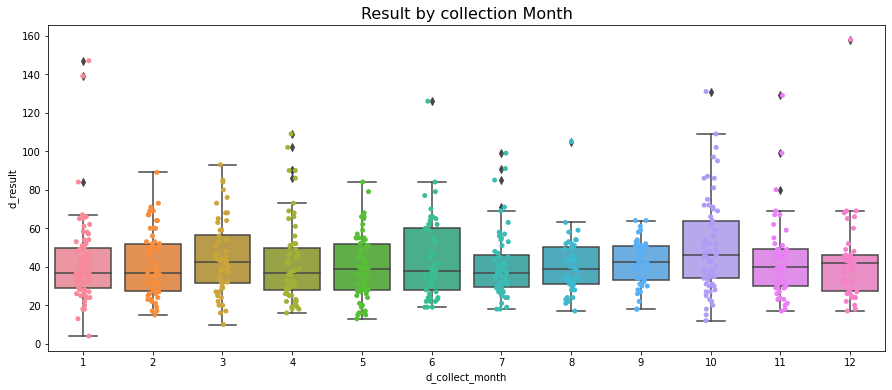

In [29]:
df.d_collect_month

plt.figure(figsize=(15,6))
sns.boxplot(x='d_collect_month', y='d_result', data=df)
sns.stripplot(x='d_collect_month', y='d_result', data=df)
plt.title('Result by collection Month', size=16)


Text(0.5, 1.0, 'dose/kg by collection Month')

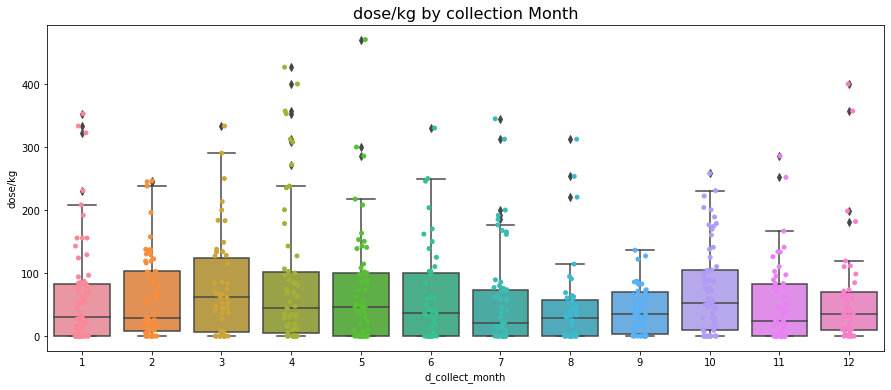

In [30]:
df.d_collect_month

plt.figure(figsize=(15,6))
sns.boxplot(x='d_collect_month', y='dose/kg', data=df)
sns.stripplot(x='d_collect_month', y='dose/kg', data=df)
plt.title('dose/kg by collection Month', size=16)

Text(0.5, 1.0, 'Result by collection Month')

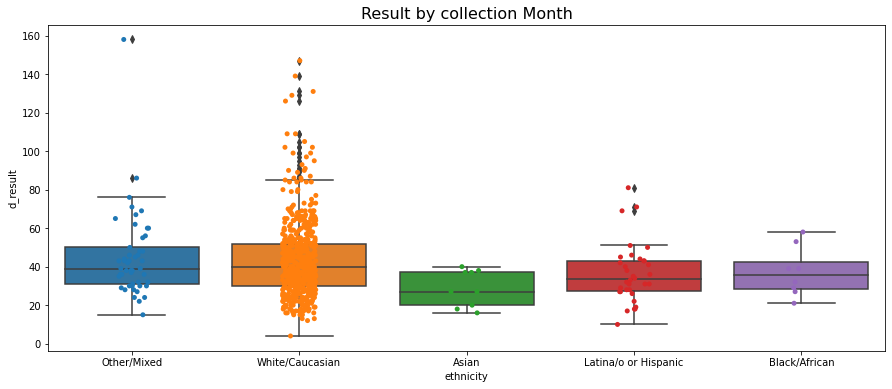

In [31]:

plt.figure(figsize=(15,6))
sns.boxplot(x='ethnicity', y='d_result', data=df)
sns.stripplot(x='ethnicity', y='d_result', data=df)
plt.title('Result by collection Month', size=16)


# Stanford

In [44]:
df=pd.read_excel('Stanford_clean.xlsx')

In [45]:
df.shape[0]

101

In [46]:
df.columns

Index(['suj_id', 'visit', 'Dose', 'Age at visit', 'Month of visit',
       'VitD_result', 'weight', 'height'],
      dtype='object')

In [47]:
df.suj_id.nunique()

21

In [48]:
df.groupby('suj_id')['Age at visit'].min().sort_values()

suj_id
19     1.8
11     1.9
15     2.0
8      2.0
10     2.1
18     2.4
12     3.6
4      4.0
14     4.8
3      6.0
13     6.7
21     9.0
1     10.1
5     10.1
20    10.2
9     11.0
2     11.9
22    15.5
17    17.4
16    19.3
7     22.4
Name: Age at visit, dtype: float64

In [49]:
pd.DataFrame(df[~df.VitD_result.isna()].groupby('suj_id').size()).groupby(0).size()

0
3     1
4     2
5    18
dtype: int64

(0.0, 13.0)

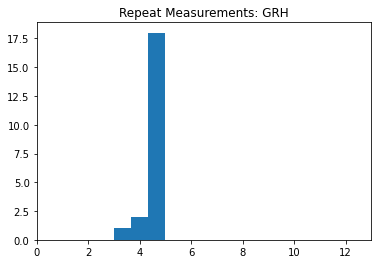

In [50]:
plt.hist(df[~df.VitD_result.isna()].groupby('suj_id').size(), bins=3)
plt.title('Repeat Measurements: GRH')
plt.xlim(0,13)

In [51]:
df.isna().sum()

suj_id            0
visit             0
Dose              0
Age at visit      0
Month of visit    0
VitD_result       0
weight            0
height            0
dtype: int64

In [52]:
df['dose/kg'] = df.Dose / df.weight.astype(float)
#df.loc[df.total_d_dosage == 0, 'dose/kg'] = 0

(0.0, 500.0)

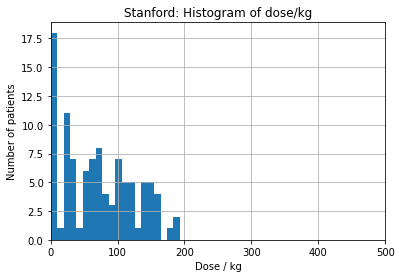

In [53]:
df['dose/kg'].hist(bins=20)
plt.xlabel('Dose / kg')
plt.ylabel('Number of patients')
plt.title('Stanford: Histogram of dose/kg')
plt.xlim([0,500])

In [54]:
df['result_corrected'] = df.VitD_result + correction_size* (- 1 +  np.cos((df['Month of visit'] - 2) /6 *3.1415 ))

(0.0, 165.0)

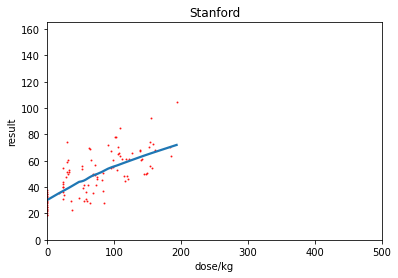

In [55]:
sns.regplot(x='dose/kg', y='result_corrected', data=df, lowess=True, scatter_kws={'color':'r', 's':1})
plt.ylabel('result')
plt.title('Stanford')
plt.xlim([0,500])
plt.ylim([0,165])

In [56]:

df['gender'] = 'M'

In [57]:
df['visit_count'] = df.sort_values(by = 'Age at visit',ascending=True).groupby('suj_id').cumcount()

df_temp = pd.merge(df[['suj_id', 'gender', 'dose/kg', 'VitD_result', 'result_corrected', 'visit_count']], df[['suj_id', 'dose/kg', 'VitD_result', 'result_corrected', 'visit_count', 'Age at visit', 'weight', 'height']], on='suj_id')
df_temp = df_temp[df_temp.visit_count_y - df_temp.visit_count_x == 1]
df_temp['change_dose'] = df_temp['dose/kg_y'] - df_temp['dose/kg_x']
df_temp['change_result'] = df_temp['VitD_result_y'] - df_temp['VitD_result_x']
df_temp['change_result_corrected'] = df_temp['result_corrected_y'] - df_temp['result_corrected_x']




In [58]:
df_temp.columns

Index(['suj_id', 'gender', 'dose/kg_x', 'VitD_result_x', 'result_corrected_x',
       'visit_count_x', 'dose/kg_y', 'VitD_result_y', 'result_corrected_y',
       'visit_count_y', 'Age at visit', 'weight', 'height', 'change_dose',
       'change_result', 'change_result_corrected'],
      dtype='object')

In [59]:
df2_change = df_temp[['suj_id',
                      'gender',
                      'VitD_result_x',
                      'result_corrected_x',
                      'dose/kg_x', 
                      'VitD_result_y', 
                      'result_corrected_y',
                      'dose/kg_y', 
                      'change_result', 
                      'change_result_corrected',
                      'change_dose', 
                      'Age at visit', 
                      'weight', 
                      'height']].rename(columns={'suj_id': 'ID',
                                                'VitD_result_x': 'result_baseline',
                                                 'result_corrected_x': 'result_baseline_corrected',
                                                'dose/kg_x': 'dose_baseline',
                                                 'VitD_result_y': 'result', 
                                                 'result_corrected_y': 'result_corrected',
                                                  'dose/kg_y': 'dose',
                                                  'Age at visit': 'age'
                                                }).copy()
df2=df.copy()

(-125.0, 125.0)

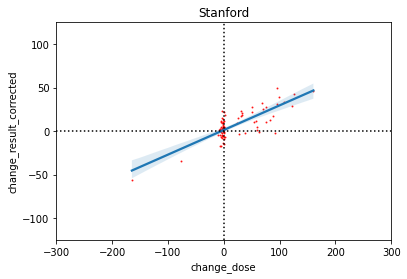

In [60]:
sns.regplot(x='change_dose', y='change_result_corrected', data=df2_change, scatter_kws={'color':'r', 's':1}, ci=95, fit_reg = True)
plt.title('Stanford')
plt.axvline(0, color = 'k', linestyle=':')
plt.axhline(0, color = 'k', linestyle=':')
plt.xlim([-300,300])
plt.ylim([-125, 125])

Text(0.5, 1.0, 'Result by collection Month')

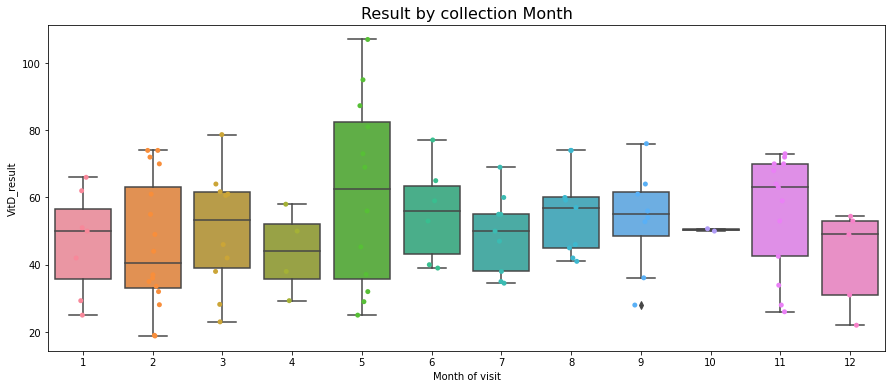

In [61]:
plt.figure(figsize=(15,6))
sns.boxplot(x='Month of visit', y='VitD_result', data=df)
sns.stripplot(x='Month of visit', y='VitD_result', data=df)
plt.title('Result by collection Month', size=16)


# Vidoma

In [62]:
df=pd.read_excel('Vidoma_clean.xlsx')

In [63]:
df.shape[0]

76

In [64]:
df.ID.nunique()

29

In [65]:
pd.DataFrame(df[~df.Result.isna()].groupby('ID').size()).groupby(0).size()

0
2    11
3    18
dtype: int64

In [66]:
df.groupby('Ethnicity').size()

Ethnicity
Asian                                              6
Maori and New Zealand European and Maori mixed     5
New Zealand European                              50
Others                                            15
dtype: int64

(0.0, 11.0)

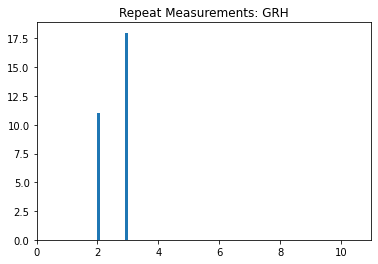

In [67]:
plt.hist(df.groupby('ID').size())
plt.title('Repeat Measurements: GRH')
plt.xlim([0,11])

In [68]:
for col in df.columns:
    df[col] = df[col].mask(df[col] == '.')
    if (col == 'weight_kg') | (col == 'height_current_cm') | (col == 'bmi'):
        df[col] = df[col].astype('float')
df.isna().sum()

ID                          0
TP                          0
Enrolment date              0
Enrolment season_NZ         0
Age (years)                 0
Gender                      0
Ethnicity                   0
Height Unadjusted (cm)      2
Height (cm)                 2
Weight Unadjusted (kg)      2
Weight (kg)                 2
Autism clinical severity    0
Compliance                  4
Result                      0
Month_north                 0
ignore                      0
age_dif                     0
Should be 0                 0
dtype: int64

In [69]:
df['dose/kg'] = 2000 / df['Weight (kg)'].astype(float)
df.loc[df.TP == 0, 'dose/kg'] = 0

(0.0, 500.0)

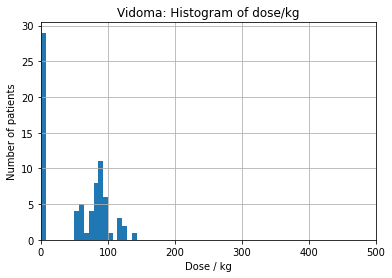

In [70]:
df['dose/kg'].hist(bins=20)
plt.xlabel('Dose / kg')
plt.ylabel('Number of patients')
plt.title('Vidoma: Histogram of dose/kg')
plt.xlim([0,500])

In [71]:
df['result_corrected'] = df.Result + correction_size* (- 1 +  np.cos((df['Month_north'] - 2) /6 *3.1415 ))

(0.0, 165.0)

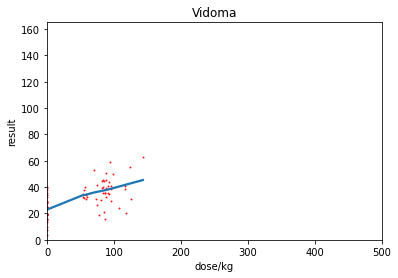

In [72]:
sns.regplot(x='dose/kg', y='result_corrected', data=df, lowess=True, scatter_kws={'color':'r', 's':1})
plt.ylabel('result')
plt.title('Vidoma')
plt.xlim([0,500])
plt.ylim([0,165])

In [73]:
df['visit_count'] = df.sort_values(by = 'Age (years)', ascending=True).groupby('ID').cumcount()

In [74]:
df.columns

Index(['ID', 'TP', 'Enrolment date', 'Enrolment season_NZ', 'Age (years)',
       'Gender', 'Ethnicity', 'Height Unadjusted (cm)', 'Height (cm)',
       'Weight Unadjusted (kg)', 'Weight (kg)', 'Autism clinical severity',
       'Compliance', 'Result', 'Month_north', 'ignore', 'age_dif',
       'Should be 0', 'dose/kg', 'result_corrected', 'visit_count'],
      dtype='object')

In [75]:
df['gender'] = 'M'
df.loc[df.Gender == 'Female', 'gender'] = 'F'

In [76]:
df_temp = pd.merge(df[['ID', 'gender', 'dose/kg', 'Result', 'result_corrected', 'visit_count']], df[['ID', 'dose/kg', 'Result', 'result_corrected', 'visit_count', 'Age (years)', 'Height (cm)', 'Weight (kg)']], on='ID')
df_temp = df_temp[df_temp.visit_count_y - df_temp.visit_count_x == 1]
df_temp['change_dose'] = df_temp['dose/kg_y'] - df_temp['dose/kg_x']
df_temp['change_result'] = df_temp['Result_y'] - df_temp['Result_x']
df_temp['change_result_corrected'] = df_temp['result_corrected_y'] - df_temp['result_corrected_x']

In [77]:
df3_change = df_temp[['ID',
                      'gender',
                      'Result_x',
                      'result_corrected_x',
                      'dose/kg_x',
                      'Result_y', 
                      'result_corrected_y',
                      'dose/kg_y',
                      'change_result',
                      'change_result_corrected',
                      'change_dose', 
                      'Age (years)', 
                      'Height (cm)', 
                      'Weight (kg)']].rename(columns={'Result_x': 'result_baseline',
                                                      'result_corrected_x': 'result_baseline_corrected',
                                                      'dose/kg_x': 'dose_baseline',
                                                      'Result_y': 'result', 
                                                      'result_corrected_y': 'result_corrected',
                                                      'dose/kg_y': 'dose',
                                                      'Age (years)': 'age', 
                                                      'Height (cm)': 'height', 
                                                      'Weight (kg)': 'weight'}).copy()
df3=df.copy()

(-125.0, 125.0)

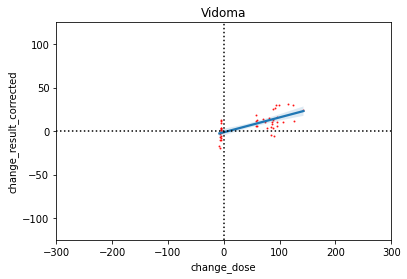

In [78]:
sns.regplot(x='change_dose', y='change_result_corrected', data=df3_change, scatter_kws={'color':'r', 's':1}, ci=95, fit_reg = True)
plt.title('Vidoma')
plt.axvline(0, color = 'k', linestyle=':')
plt.axhline(0, color = 'k', linestyle=':')
plt.xlim([-300,300])
plt.ylim([-125, 125])

Text(0.5, 1.0, 'Result by collection Month')

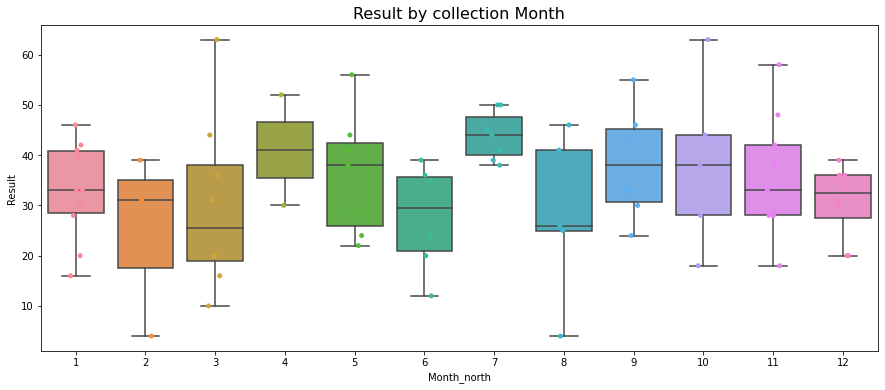

In [79]:
plt.figure(figsize=(15,6))
sns.boxplot(x='Month_north', y='Result', data=df)
sns.stripplot(x='Month_north', y='Result', data=df)
plt.title('Result by collection Month', size=16)


In [72]:
#pip install pygrowup

In [68]:
# adjust weights for 3 and 6 months later
from pygrowup import Calculator
calculator = Calculator(adjust_height_data=False, adjust_weight_scores=False,
                       include_cdc=True, logger_name='pygrowup',
                       log_level='INFO')

In [69]:
weight_at_baseline = 29.9
age_at_baseline = 3.5
gender = 'M'

z_baseline= calculator.wfa(weight_at_baseline, age_at_baseline * 12, gender)

#find weight at 6 months
df_ans = pd.DataFrame(columns = ['shift', 'new_z'])
for shift in range(0,50):
    df_ans.loc[shift] = [shift/10, z_baseline - calculator.wfa(weight_at_baseline + shift/10, age_at_baseline * 12 + 6, gender)]
df_ans['zsquared'] = df_ans.new_z**2
df_ans['zsquared'] = df_ans.zsquared.astype(float)
weight_at_6_mo = weight_at_baseline + df_ans.loc[df_ans.zsquared.idxmin(), 'shift']


#find weight at 12 months
df_ans = pd.DataFrame(columns = ['shift', 'new_z'])
for shift in range(0,80):
    df_ans.loc[shift] = [shift/10, z_baseline - calculator.wfa(weight_at_baseline + shift/10, age_at_baseline * 12 + 12, gender)]
df_ans['zsquared'] = df_ans.new_z**2
df_ans['zsquared'] = df_ans.zsquared.astype(float)
weight_at_12_mo = weight_at_baseline + df_ans.loc[df_ans.zsquared.idxmin(), 'shift']


In [70]:
weight_at_6_mo

34.199999999999996

In [71]:
weight_at_12_mo

37.8

In [72]:
z_baseline

Decimal('4.48')

In [73]:
#adjust heights for 3 and 6 months later

In [74]:
pp = 29

height_at_baseline = df[df.TP == 0].loc[df.ID == pp]['Height (cm)'].values[0]
age_at_baseline = df[df.TP == 0].loc[df.ID == pp]['Age (years)'].values[0]
gender = 'M'
if df[df.TP == 0].loc[df.ID == pp]['Gender'].values[0] == 'Female':
    gender = 'F'

z_baseline= calculator.lhfa(height_at_baseline, age_at_baseline * 12, gender)

#find height at 6 months
df_ans = pd.DataFrame(columns = ['shift', 'new_z'])
for shift in range(0,100):
    df_ans.loc[shift] = [shift/5, z_baseline - calculator.lhfa(height_at_baseline + shift/5, age_at_baseline * 12 + 6, gender)]
df_ans['zsquared'] = df_ans.new_z**2
df_ans['zsquared'] = df_ans.zsquared.astype(float)
height_at_6_mo = height_at_baseline + df_ans.loc[df_ans.zsquared.idxmin(), 'shift']


#find height at 12 months
df_ans = pd.DataFrame(columns = ['shift', 'new_z'])
for shift in range(0,150):
    df_ans.loc[shift] = [shift/5, z_baseline - calculator.lhfa(height_at_baseline + shift/5, age_at_baseline * 12 + 12, gender)]
df_ans['zsquared'] = df_ans.new_z**2
df_ans['zsquared'] = df_ans.zsquared.astype(float)
height_at_12_mo = height_at_baseline + df_ans.loc[df_ans.zsquared.idxmin(), 'shift']


In [75]:
height_at_6_mo

101.3

In [76]:
height_at_12_mo

104.1

In [77]:
z_baseline

Decimal('-2.27')

# Change from starting vitamin D

In [80]:
df1_change['dataset'] = 'GRH'
df2_change['dataset'] = 'Stanford'
df3_change['dataset'] = 'Vidoma'
df_change = pd.concat([df1_change, df2_change, df3_change])

df_change['ID'] = df_change['dataset'].str[0] + df_change['ID'].astype(str)

In [81]:
df_change

,ID,gender,result_baseline,result_baseline_corrected,dose_baseline,result,result_corrected,dose,change_result,change_result_corrected,change_dose,age,weight,height,dataset
315,G312,M,18.0,16.599626,0.000000,40.0,37.200130,36.743710,22.0,20.600504,36.743710,2.757016,13.607771,100.00,GRH
319,G313,F,39.0,34.799700,46.413108,54.0,51.200130,84.793178,15.0,16.400429,38.380070,17.407255,58.967008,150.00,GRH
323,G314,M,36.0,33.199611,0.000000,39.0,37.600075,34.994010,3.0,4.400464,34.994010,9.563313,28.576319,116.84,GRH
331,G316,M,35.0,32.199611,0.000000,65.0,60.800150,39.368261,30.0,28.600539,39.368261,2.047912,12.700586,90.00,GRH
335,G317,M,21.0,18.200130,0.000000,44.0,43.624893,79.355556,23.0,25.424763,79.355556,13.259411,45.000000,150.00,GRH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,V26,M,50.0,44.775237,81.632653,42.0,41.624893,74.906367,-8.0,-3.150344,-6.726286,4.670000,26.700000,113.20,Vidoma
190,V27,M,30.0,28.599626,0.000000,39.0,34.800150,58.997050,9.0,6.200524,58.997050,7.250000,33.900000,136.10,Vidoma
194,V27,M,39.0,34.800150,58.997050,39.0,37.599626,54.945055,0.0,2.799476,-4.051995,7.750000,36.400000,139.70,Vidoma
199,V28,M,4.0,4.000000,0.000000,4.0,-1.600000,89.686099,0.0,-5.600000,89.686099,3.670000,22.300000,107.00,Vidoma


In [82]:
df_change.dropna(inplace=True)

In [83]:
df_change.shape

(263, 15)

In [84]:
df_change = df_change[df_change.age < 18].copy()

In [85]:
df_change.groupby('dataset').size()

dataset
GRH         137
Stanford     70
Vidoma       46
dtype: int64

In [86]:
df_change.groupby('dataset')['ID'].nunique() #/ 124 * 100

dataset
GRH         77
Stanford    19
Vidoma      28
Name: ID, dtype: int64

In [87]:
df_change.groupby('gender')['ID'].nunique() #/ 124 * 100

gender
F    42
M    82
Name: ID, dtype: int64

In [88]:
253/124

2.0403225806451615

In [89]:
grh_ids = df_change[df_change.dataset == 'GRH'].ID.str[1:].drop_duplicates()
stanford_ids = df_change[df_change.dataset == 'Stanford'].ID.str[1:].drop_duplicates()
vidoma_ids = df_change[df_change.dataset == 'Vidoma'].ID.str[1:].drop_duplicates()

In [90]:
df_change.groupby('ID')['age'].min().describe()

count    124.000000
mean       8.262339
std        4.416517
min        0.878850
25%        4.793249
50%        7.375000
75%       11.246704
max       17.946612
Name: age, dtype: float64

<AxesSubplot:>

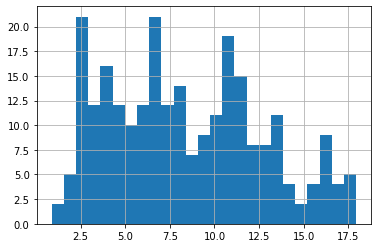

In [91]:
df_change.age.hist(bins=25)

Text(0.5, 1.0, 'Older patients take smaller doses')

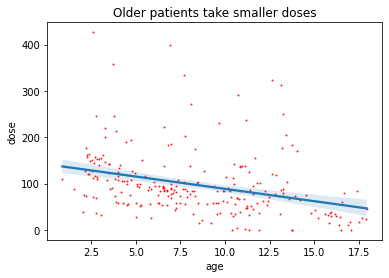

In [92]:
sns.regplot(x='age', y='dose', data=df_change, ci=95, order=1, scatter_kws={'color':'r', 's':1})
plt.title('Older patients take smaller doses')

<AxesSubplot:>

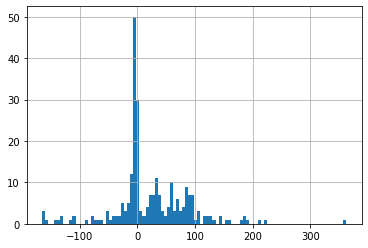

In [93]:
df_change.change_dose.hist(bins=100)

In [94]:
df_change.columns

Index(['ID', 'gender', 'result_baseline', 'result_baseline_corrected',
       'dose_baseline', 'result', 'result_corrected', 'dose', 'change_result',
       'change_result_corrected', 'change_dose', 'age', 'weight', 'height',
       'dataset'],
      dtype='object')

<AxesSubplot:xlabel='result_baseline'>

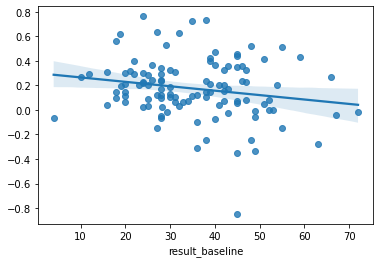

In [95]:
df_temp = df_change[df_change.change_dose > 20]
sns.regplot(y=df_temp.change_result_corrected/df_temp.change_dose, x=df_temp.result_baseline)

Text(0, 0.5, 'Baseline VitD')

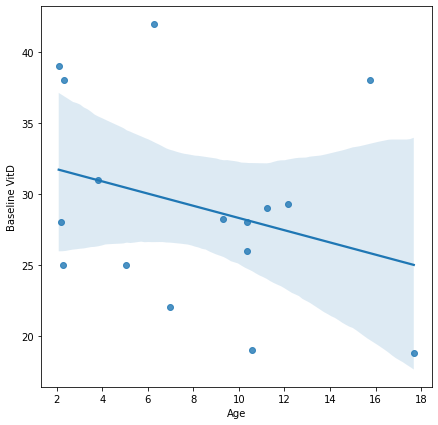

In [96]:
plt.figure(figsize=(7,7))
df_temp = df_change[(np.abs(df_change.change_dose) > 10) & 
                    (np.abs(df_change.change_dose) < 200) & 
                    (np.abs(df_change.dose_baseline) < 1) & 
                    (df_change.dataset == 'Stanford')]
sns.regplot(y=df_temp.result_baseline, x=df_temp.age)
plt.xlabel('Age')
plt.ylabel('Baseline VitD')

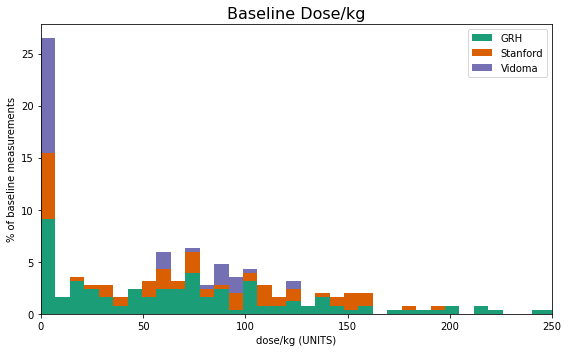

In [97]:
feature = 'dose_baseline'

x1 = df_change[df_change.dataset == 'GRH'][feature]
x2 = df_change[df_change.dataset == 'Stanford'][feature]
x3 = df_change[df_change.dataset == 'Vidoma'][feature]
w1 = np.ones_like(df_change[df_change.dataset == 'GRH'][feature]) * 100 / len(df_change.dose_baseline)
w2 = np.ones_like(df_change[df_change.dataset == 'Stanford'][feature]) * 100 / len(df_change.dose_baseline)
w3 = np.ones_like(df_change[df_change.dataset == 'Vidoma'][feature]) * 100 / len(df_change.dose_baseline)

plt.figure(figsize=(8,5))

plt.hist([x1, x2, x3], bins=50, stacked = True, weights = [w1, w2, w3], color = colors, label = ['GRH', 'Stanford', 'Vidoma'])
plt.legend()

plt.xlim([0,250])

plt.ylabel('% of baseline measurements')
plt.xlabel('dose/kg (UNITS)')
plt.title('Baseline Dose/kg', fontsize=16)

plt.tight_layout()
plt.savefig('temp.jpg')

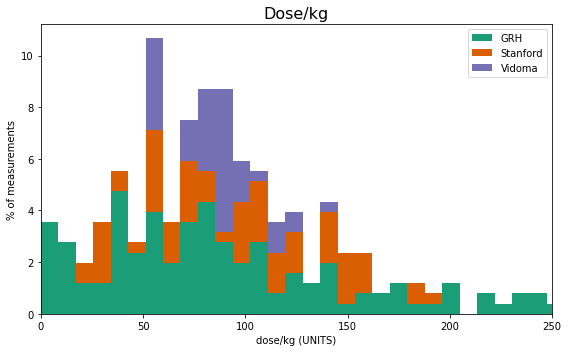

In [98]:
feature = 'dose'

x1 = df_change[df_change.dataset == 'GRH'][feature]
x2 = df_change[df_change.dataset == 'Stanford'][feature]
x3 = df_change[df_change.dataset == 'Vidoma'][feature]
w1 = np.ones_like(df_change[df_change.dataset == 'GRH'][feature]) * 100 / len(df_change.dose_baseline)
w2 = np.ones_like(df_change[df_change.dataset == 'Stanford'][feature]) * 100 / len(df_change.dose_baseline)
w3 = np.ones_like(df_change[df_change.dataset == 'Vidoma'][feature]) * 100 / len(df_change.dose_baseline)

plt.figure(figsize=(8,5))

plt.hist([x1, x2, x3], bins=50, stacked = True, weights = [w1, w2, w3], color = colors, label = ['GRH', 'Stanford', 'Vidoma'])
plt.legend()

plt.xlim([0,250])

plt.ylabel('% of measurements')
plt.xlabel('dose/kg (UNITS)')
plt.title('Dose/kg', fontsize=16)

plt.tight_layout()
plt.savefig('temp.jpg')

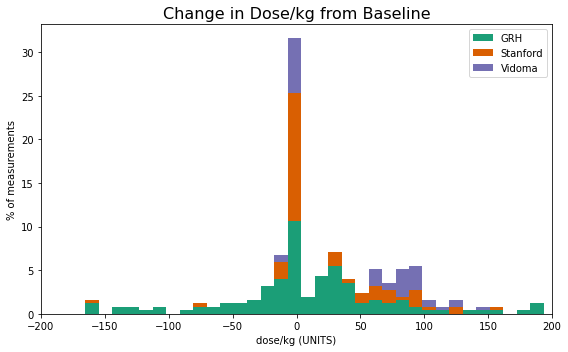

In [99]:
feature = 'change_dose'

x1 = df_change[df_change.dataset == 'GRH'][feature]
x2 = df_change[df_change.dataset == 'Stanford'][feature]
x3 = df_change[df_change.dataset == 'Vidoma'][feature]
w1 = np.ones_like(df_change[df_change.dataset == 'GRH'][feature]) * 100 / len(df_change.dose_baseline)
w2 = np.ones_like(df_change[df_change.dataset == 'Stanford'][feature]) * 100 / len(df_change.dose_baseline)
w3 = np.ones_like(df_change[df_change.dataset == 'Vidoma'][feature]) * 100 / len(df_change.dose_baseline)

plt.figure(figsize=(8,5))

plt.hist([x1, x2, x3], bins=50, stacked = True, weights = [w1, w2, w3], color = colors, label = ['GRH', 'Stanford', 'Vidoma'])
plt.legend()

plt.xlim([-200,200])

plt.ylabel('% of measurements')
plt.xlabel('dose/kg (UNITS)')
plt.title('Change in Dose/kg from Baseline', fontsize=16)

plt.tight_layout()
plt.savefig('temp.jpg')

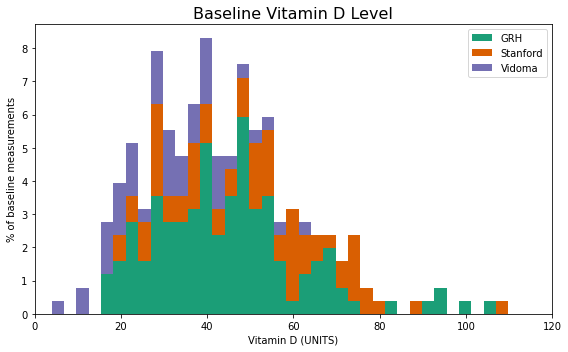

In [100]:
feature = 'result_baseline'

x1 = df_change[df_change.dataset == 'GRH'][feature]
x2 = df_change[df_change.dataset == 'Stanford'][feature]
x3 = df_change[df_change.dataset == 'Vidoma'][feature]
w1 = np.ones_like(df_change[df_change.dataset == 'GRH'][feature]) * 100 / len(df_change.dose_baseline)
w2 = np.ones_like(df_change[df_change.dataset == 'Stanford'][feature]) * 100 / len(df_change.dose_baseline)
w3 = np.ones_like(df_change[df_change.dataset == 'Vidoma'][feature]) * 100 / len(df_change.dose_baseline)

plt.figure(figsize=(8,5))

plt.hist([x1, x2, x3], bins=50, stacked = True, weights = [w1, w2, w3], color = colors, label = ['GRH', 'Stanford', 'Vidoma'])
plt.legend()

plt.xlim([0,120])

plt.ylabel('% of baseline measurements')
plt.xlabel('Vitamin D (UNITS)')
plt.title('Baseline Vitamin D Level', fontsize=16)

plt.tight_layout()
plt.savefig('temp.jpg')

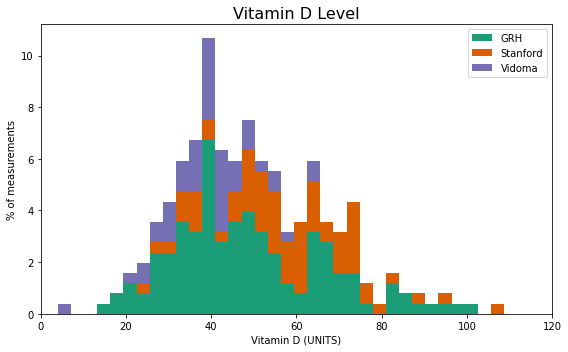

In [101]:
feature = 'result'

x1 = df_change[df_change.dataset == 'GRH'][feature]
x2 = df_change[df_change.dataset == 'Stanford'][feature]
x3 = df_change[df_change.dataset == 'Vidoma'][feature]
w1 = np.ones_like(df_change[df_change.dataset == 'GRH'][feature]) * 100 / len(df_change.dose_baseline)
w2 = np.ones_like(df_change[df_change.dataset == 'Stanford'][feature]) * 100 / len(df_change.dose_baseline)
w3 = np.ones_like(df_change[df_change.dataset == 'Vidoma'][feature]) * 100 / len(df_change.dose_baseline)

plt.figure(figsize=(8,5))

plt.hist([x1, x2, x3], bins=50, stacked = True, weights = [w1, w2, w3], color = colors, label = ['GRH', 'Stanford', 'Vidoma'])
plt.legend()

plt.xlim([0,120])

plt.ylabel('% of measurements')
plt.xlabel('Vitamin D (UNITS)')
plt.title('Vitamin D Level', fontsize=16)

plt.tight_layout()
plt.savefig('temp.jpg')

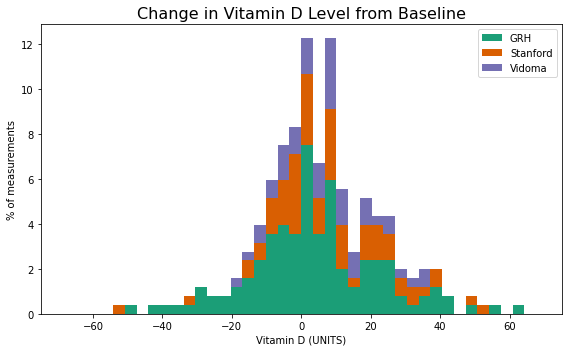

In [102]:
feature = 'change_result'

x1 = df_change[df_change.dataset == 'GRH'][feature]
x2 = df_change[df_change.dataset == 'Stanford'][feature]
x3 = df_change[df_change.dataset == 'Vidoma'][feature]
w1 = np.ones_like(df_change[df_change.dataset == 'GRH'][feature]) * 100 / len(df_change.dose_baseline)
w2 = np.ones_like(df_change[df_change.dataset == 'Stanford'][feature]) * 100 / len(df_change.dose_baseline)
w3 = np.ones_like(df_change[df_change.dataset == 'Vidoma'][feature]) * 100 / len(df_change.dose_baseline)

plt.figure(figsize=(8,5))

plt.hist([x1, x2, x3], bins=50, stacked = True, weights = [w1, w2, w3], color = colors, label = ['GRH', 'Stanford', 'Vidoma'])
plt.legend()

plt.xlim([-75,75])

plt.ylabel('% of measurements')
plt.xlabel('Vitamin D (UNITS)')
plt.title('Change in Vitamin D Level from Baseline', fontsize=16)

plt.tight_layout()
plt.savefig('temp.jpg')

In [107]:
df_change.groupby('ID').weight.min().describe()

count    124.000000
mean      29.820369
std       15.410955
min        7.257478
25%       18.962500
50%       25.000000
75%       35.000000
max       80.100000
Name: weight, dtype: float64

In [103]:
df_change1 = df_change[df_change.dataset == 'GRH'].copy()
df_change2 = df_change[df_change.dataset == 'Stanford'].copy()
df_change3 = df_change[df_change.dataset == 'Vidoma'].copy()

In [102]:
mod = smf.gee('change_result_corrected ~ 0 + change_dose ',
              'ID',
              df_change,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit(first_dep_update=200,params_niter = 200, maxiter = 10000)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                GEE Regression Results                                
======================================================================================
Dep. Variable:        change_result_corrected   No. Observations:                  253
Model:                                    GEE   No. clusters:                      124
Method:                           Generalized   Min. cluster size:                   1
                         Estimating Equations   Max. cluster size:                   9
Family:                              Gaussian   Mean cluster size:                 2.0
Dependence structure:            Exchangeable   Num. iterations:                   203
Date:                        Thu, 13 Apr 2023   Scale:                         323.193
Covariance type:                       robust   Time:                         16:54:03
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
change_dose     0.1557      0.031      5.057      0.000       0.095       0.216
==============================================================================
Skew:                          1.4340   Kurtosis:                       5.3378
Centered skew:                 0.0084   Centered kurtosis:              5.2236
==============================================================================
"""

In [103]:
#bmi
df_change['bmi'] = df_change.weight / ((df_change.height/100)**2)

In [104]:
from pygrowup import Calculator
calculator = Calculator(adjust_height_data=False, adjust_weight_scores=False,
                       include_cdc=True, logger_name='pygrowup',
                       log_level='INFO')

In [105]:
df_change.reset_index(inplace=True)

def get_bmi_z_score(ii):
    bmi_val = df_change.iloc[ii]['bmi']
    age_val = df_change.iloc[ii]['age']
    gender_val = df_change.iloc[ii]['gender']

    return float(calculator.bmifa(bmi_val, age_val * 12, gender_val))

df_change['bmi_z_score'] = df_change.index.map(get_bmi_z_score)

Text(0.5, 1.0, 'BMI distribution')

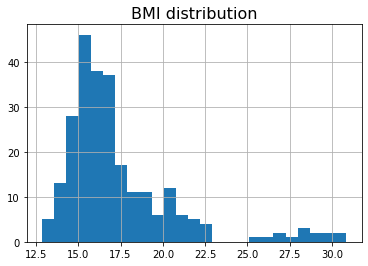

In [106]:
df_change.bmi.hist(bins=25)
plt.title('BMI distribution', fontsize=16)

Text(0.5, 1.0, 'BMI z-score distribution')

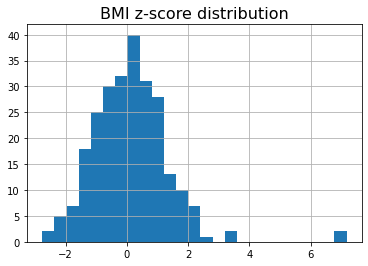

In [107]:
df_change.bmi_z_score.hist(bins=25)
plt.title('BMI z-score distribution', fontsize=16)

In [108]:
df_change.bmi_z_score.mean()

0.12252964426877468

In [109]:
df_change.bmi_z_score.std()

1.2327784804480588

<AxesSubplot:>

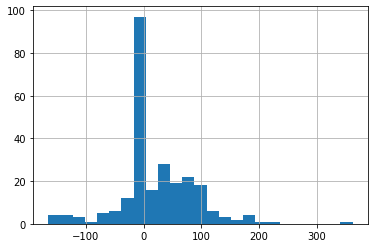

In [110]:
df_change.change_dose.hist(bins=25)
#plt.title('BMI z-score distribution', fontsize=16)

<AxesSubplot:>

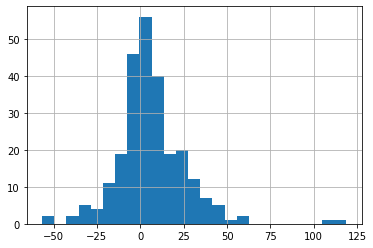

In [111]:
df_change.change_result_corrected.hist(bins=25)
#plt.title('BMI z-score distribution', fontsize=16)

In [112]:
#df_change.loc[df_change.bmi_z_score > 3, 'bmi_z_score'] = 3

In [272]:
df_change['AGE'] =  np.log(1 + df_change.age/18)   #(df_change.age.clip(upper=18, lower = 0) - df_change.age.mean())/10
df_change['BMI'] = df_change.bmi - df_change.bmi.mean()

In [273]:
df_change.columns

Index(['index', 'ID', 'gender', 'result_baseline', 'result_baseline_corrected',
       'dose_baseline', 'result', 'result_corrected', 'dose', 'change_result',
       'change_result_corrected', 'change_dose', 'age', 'weight', 'height',
       'dataset', 'bmi', 'bmi_z_score', 'AGE', 'BMI'],
      dtype='object')

In [280]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

df_temp = df_change[(df_change.change_result < 75) & (df_change.change_dose < 225)].copy()

df_aic=pd.DataFrame([], columns=['change_dose', 'base_result', 'base_dose', 'age', 'bmi_z_score', 'aic', 'bic'])
ii = 0
for rr in [0,1]:
    for dd in [0,1]:
        for aa in [0,1]:
            for bmi in [0,1]:
                ff = 'change_result_corrected ~ 0 + change_dose'
                if rr == 1:
                    ff += ' + change_dose:result_baseline'
                if dd == 1:
                    ff += ' + change_dose:dose_baseline'
                if aa == 1:
                    ff += ' + change_dose:AGE'
                if bmi == 1:
                    ff += ' + change_dose:bmi_z_score'
                model = sm.MixedLM.from_formula(ff, 
                                vc_formula={"ID": "0 + C(ID)"},# "dataset": "0+C(dataset)"},
                                re_formula="~1",
                                groups="dataset",
                                data=df_temp)                                                   
                result = model.fit(method='powell', reml=False) 
                coef_1 = float(result.summary().tables[1]['Coef.']['change_dose'])
                coef_2 = 0
                coef_3 = 0
                coef_4 = 0
                coef_5 = 0
                if rr == 1:
                    coef_2 = float(result.summary().tables[1]['Coef.']['change_dose:result_baseline'])
                if dd == 1:
                    coef_3 = float(result.summary().tables[1]['Coef.']['change_dose:dose_baseline'])
                if aa == 1:
                    coef_4 = float(result.summary().tables[1]['Coef.']['change_dose:AGE'])
                if bmi == 1:
                    coef_5 = float(result.summary().tables[1]['Coef.']['change_dose:bmi_z_score'])
                aic = result.aic
                bic = result.bic
                df_aic.loc[ii] = [coef_1, coef_2, coef_3, coef_4, coef_5, aic,bic]
                ii += 1

In [281]:
df_aic.sort_values(by='bic')

,change_dose,base_result,base_dose,age,bmi_z_score,aic,bic
14,0.169,0.004,-0.001,-0.278,0.000,2049.473571,2074.123797
12,0.077,0.004,-0.001,0.000,0.000,2054.553936,2075.682701
13,0.064,0.004,-0.001,0.000,0.026,2052.756515,2077.406741
15,0.148,0.004,-0.001,-0.233,0.013,2050.744727,2078.916414
6,0.308,0.000,-0.001,-0.320,0.000,2070.576772,2091.705538
4,0.207,0.000,-0.001,0.000,0.000,2077.078105,2094.685410
7,0.308,0.000,-0.001,-0.319,0.000,2072.576739,2097.226965
5,0.203,0.000,-0.001,0.000,0.018,2077.520473,2098.649239
2,0.292,0.000,0.000,-0.470,0.000,2090.540886,2108.148191
10,0.222,0.002,0.000,-0.476,0.000,2087.680184,2108.808950


In [285]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

df_temp = df_change[(df_change.change_result < 75) & (df_change.change_dose < 225)].copy()

df_aic=pd.DataFrame([], columns=['model', 'change_dose', 'base_result', 'base_dose', 'age', 'age_2', 'age_3', 'age_4', 'aic', 'bic'])
ii = 0
for rr in ['log','logoneplus', 'loghalfplus', 'log2plus', 'linear', 'sqrt', 'spline2', 'spline3', 'spline4']:
    
    df_temp = df_change[(df_change.change_result < 75) & (df_change.change_dose < 225)].copy()
    
    ff = 'change_result_corrected ~ 0 + change_dose + change_dose:result_baseline + change_dose:dose_baseline + change_dose:AGE'

    
    if rr == 'log':
        df_temp['AGE'] =  np.log(df_temp.age)
    if rr == 'logoneplus':
        df_temp['AGE'] =  np.log(1 + df_temp.age/18)
    if rr == 'loghalfplus':
        df_temp['AGE'] =  np.log(0.5 + df_temp.age/18)
    if rr == 'log2plus':
        df_temp['AGE'] =  np.log(2 + df_temp.age/18)
    if rr == 'linear':
        df_temp['AGE'] =  df_temp.age
    if rr == 'sqrt':
        df_temp['AGE'] =  df_temp.age**0.5
    if rr == 'spline2':
        ff += ' + change_dose:AGE_2'
        transformed_x = dmatrix("bs(df_temp.age, df=2, degree=1)", {"df_temp.age": df_temp.age}, return_type='dataframe')
        df_temp = pd.concat([df_temp, transformed_x],axis=1).rename(columns={'bs(df_temp.age, df=2, degree=1)[0]':'comp_1',
                                                     'bs(df_temp.age, df=2, degree=1)[1]':'comp_2'}).copy()
        df_temp['AGE'] =  df_temp.comp_1
        df_temp['AGE_2'] =  df_temp.comp_2
    if rr == 'spline3':
        ff += ' + change_dose:AGE_2  + change_dose:AGE_3'
        transformed_x = dmatrix("cr(df_temp.age, df=3)", {"df_temp.age": df_temp.age}, return_type='dataframe')
        df_temp = pd.concat([df_temp, transformed_x],axis=1).rename(columns={'cr(df_temp.age, df=3)[0]':'comp_1',
                                                     'cr(df_temp.age, df=3)[1]':'comp_2',
                                                     'cr(df_temp.age, df=3)[2]':'comp_3'}).copy()
        df_temp['AGE'] =  df_temp.comp_1
        df_temp['AGE_2'] =  df_temp.comp_2
        df_temp['AGE_3'] =  df_temp.comp_3
    if rr == 'spline4':
        ff += ' + change_dose:AGE_2  + change_dose:AGE_3 + change_dose:AGE_4'
        transformed_x = dmatrix("cr(df_temp.age, df=4)", {"df_temp.age": df_temp.age}, return_type='dataframe')
        df_temp = pd.concat([df_temp, transformed_x],axis=1).rename(columns={'cr(df_temp.age, df=4)[0]':'comp_1',
                                                     'cr(df_temp.age, df=4)[1]':'comp_2',
                                                     'cr(df_temp.age, df=4)[2]':'comp_3',
                                                     'cr(df_temp.age, df=4)[3]':'comp_4'}).copy()
        df_temp['AGE'] =  df_temp.comp_1 
        df_temp['AGE_2'] =  df_temp.comp_2
        df_temp['AGE_3'] =  df_temp.comp_3
        df_temp['AGE_4'] =  df_temp.comp_4
        
        
    #model = sm.MixedLM.from_formula(ff, 
    #                            vc_formula={"ID": "0 + C(ID)"},# "dataset": "0+C(dataset)"},
    #                            re_formula="~1",
    #                            groups="dataset",
    #                            data=df_temp) 
    model = sm.MixedLM.from_formula(ff, 
                                groups="ID",
                                data=df_temp) 
    result = model.fit(method='powell', reml=False) 
    
    coef_change_dose = float(result.summary().tables[1]['Coef.']['change_dose'])
    coef_result_base= float(result.summary().tables[1]['Coef.']['change_dose:result_baseline'])
    coef_dose_base = float(result.summary().tables[1]['Coef.']['change_dose:dose_baseline'])
    coef_age_1 = float(result.summary().tables[1]['Coef.']['change_dose:AGE'])
    coef_age_2 = 0
    coef_age_3 = 0
    coef_age_4 = 0
    if rr == 'spline2':
        coef_age_2 = float(result.summary().tables[1]['Coef.']['change_dose:AGE_2'])
    if rr == 'spline3':
        coef_age_2 = float(result.summary().tables[1]['Coef.']['change_dose:AGE_2'])
        coef_age_3 = float(result.summary().tables[1]['Coef.']['change_dose:AGE_3'])
    if rr == 'spline4':
        coef_age_2 = float(result.summary().tables[1]['Coef.']['change_dose:AGE_2'])
        coef_age_3 = float(result.summary().tables[1]['Coef.']['change_dose:AGE_3'])
        coef_age_4 = float(result.summary().tables[1]['Coef.']['change_dose:AGE_4'])
                
        
                
                
    aic = result.aic
    bic = result.bic
    df_aic.loc[ii] = [rr,
                      coef_change_dose,
                      coef_result_base,
                      coef_dose_base,
                      coef_age_1,
                      coef_age_2,
                      coef_age_3,
                      coef_age_4,
                      aic,bic]
    ii += 1

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2705: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2705: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


In [286]:
df_aic.sort_values(by='bic')

,model,change_dose,base_result,base_dose,age,age_2,age_3,age_4,aic,bic
4,linear,0.158,0.004,-0.001,-0.011,0.000,0.000,0.0,2047.876123,2069.004889
3,log2plus,0.489,0.004,-0.001,-0.468,0.000,0.000,0.0,2047.878647,2069.007413
1,logoneplus,0.171,0.004,-0.001,-0.274,0.000,0.000,0.0,2047.915105,2069.043871
2,loghalfplus,0.059,0.004,-0.001,-0.176,0.000,0.000,0.0,2048.001549,2069.130314
5,sqrt,0.227,0.004,-0.001,-0.056,0.000,0.000,0.0,2048.127527,2069.256293
0,log,0.204,0.004,-0.001,-0.067,0.000,0.000,0.0,2048.851297,2069.980063
6,spline2,0.140,0.004,-0.001,-0.060,-0.183,0.000,0.0,2049.817431,2074.467657
7,spline3,-3.909,0.004,-0.001,4.057,3.980,3.875,0.0,2051.875340,2080.047027
8,spline4,-0.058,0.004,-0.001,0.165,0.161,0.082,0.1,2053.035780,2084.728928


<AxesSubplot:>

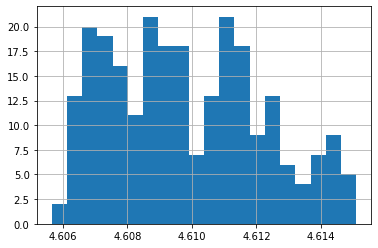

In [278]:
np.log(100 + df_temp.age/18).hist(bins=20)

In [311]:
#md = smf.mixedlm('change_dose ~ 0 + change_result + C(dataset)', df_change, groups=df_change['ID'])
#mdf = md.fit()
#print(mdf.summary())

df_temp = df_change[(df_change.change_result < 75) & (df_change.change_dose < 225)].copy()
#df_temp.loc[df_temp.change_dose < 0, 'change_result'] = - df_temp.change_result
#df_temp.loc[df_temp.change_dose < 0, 'change_dose'] = - df_temp.change_dose

g1 = "change_result ~ 0 + change_dose"
g2 = "change_result ~ 0 + change_dose + change_dose:result_baseline + change_dose:dose_baseline"
g3 = "change_result ~ 0 + change_dose + change_dose:result_baseline + change_dose:dose_baseline + change_dose:AGE + change_dose:bmi_z_score"
gg = "change_result ~ 0 + change_dose + change_dose:result_baseline + change_dose:dose_baseline + change_dose:AGE"


f1 = "change_result_corrected ~ 0 + change_dose"
f2 = "change_result_corrected ~ 0 + change_dose + change_dose:result_baseline_corrected + change_dose:dose_baseline"
f3 = "change_result_corrected ~ 0 + change_dose + change_dose:result_baseline_corrected + change_dose:dose_baseline + change_dose:AGE + change_dose:bmi_z_score"
ffinal = "change_result_corrected ~ 0 + change_dose + change_dose:result_baseline_corrected + change_dose:dose_baseline + change_dose:AGE"

df_temp['AGE'] =  np.log(1 + df_change.age/18)

ff = ffinal


sp1 = sm.OLS.from_formula(ff, data=df_temp).fit().summary2().tables[1]['Coef.']
 
model = sm.MixedLM.from_formula(ff, 
                                vc_formula={"ID": "0 + C(ID)"},# "dataset": "0+C(dataset)"},
                                re_formula="~1",
                                groups="dataset",
                                data=df_temp)                                                   
result = model.fit(method='powell', reml=True)   #lbfgs, powell, cg, bfgs

result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
================================================================================
Model:                 MixedLM    Dependent Variable:    change_result_corrected
No. Observations:      250        Method:                REML                   
No. Groups:            3          Scale:                 202.5151               
Min. group size:       46         Log-Likelihood:        -1036.5254             
Max. group size:       134        Converged:             Yes                    
Mean group size:       83.3                                                     
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
change_dose                            0.180    0.046  3.948 0.000  0.091  0.269
change_dose:result_baseline_corrected  0.004    0.001  5.314 0.000  0.002  0.005
change_dose:dose_baseline             -0.001    0.000 -6.740 0.000 -0.001 -0.001
change_dose:AGE                       -0.288    0.104 -2.759 0.006 -0.492 -0.083
dataset Var                            2.668    0.338                           
ID Var                                 0.000                                    
================================================================================

"""

In [312]:
np.round(result.params,4)

change_dose                              0.1798
change_dose:result_baseline_corrected    0.0038
change_dose:dose_baseline               -0.0011
change_dose:AGE                         -0.2875
dataset Var                              0.0132
ID Var                                   0.0000
dtype: float64

In [313]:
np.round(1.96 * result.bse_fe,4)

change_dose                              0.0893
change_dose:result_baseline_corrected    0.0014
change_dose:dose_baseline                0.0003
change_dose:AGE                          0.2043
dtype: float64

In [290]:
#example from document
30 * (40-25) / (0.18 + 0.0038 * 25  - 0.0011 * 600/30  - 0.288 * np.log(1 + 10.5/18))

3729.6519779810956

In [292]:
#what's the relationship for 18-year olds who aren't on supplements?
(0.18 + 0.0038 * 25  - 0.0011 * 0  - 0.288 * np.log(1 + 18/18)) * 100

7.53736119987358

In [294]:
#What's the lowest slope you can reasonably get?
(0.18 + 0.0038 * 10  - 0.0011 * 100  - 0.288 * np.log(1 + 18/18)) 

-0.09162638800126423

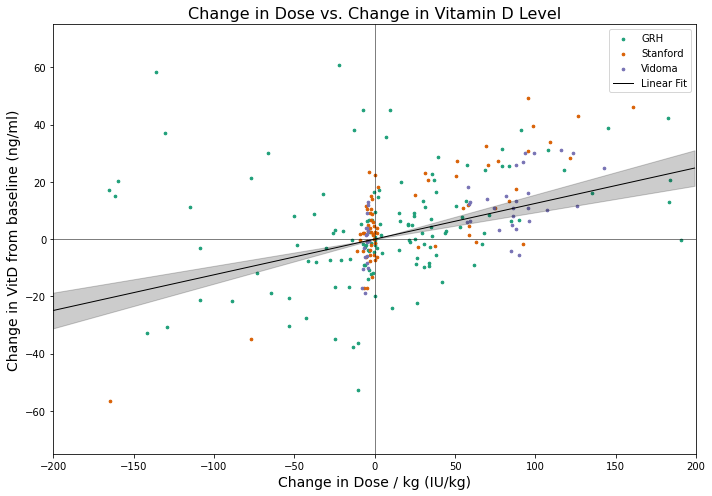

In [302]:
plt.figure(figsize=[10,7])

plt.scatter(df_change1['change_dose'], df_change1['change_result_corrected'], label = 'GRH', s=7, color = colors[0])
plt.scatter(df_change2['change_dose'], df_change2['change_result_corrected'], label = 'Stanford', s=7, color = colors[1])
plt.scatter(df_change3['change_dose'], df_change3['change_result_corrected'], label = 'Vidoma', s=7, color = colors[2])

df_temp = df_change[(df_change.change_result < 75) & (df_change.change_dose < 200)]

#sns.regplot(x = df_temp['change_dose'], y = df_temp['change_result_corrected'],  ci=95, scatter=False, line_kws={'color':'black', 'linewidth': '1'}, label='Linear Fit')



x = np.arange(-200, 200, 1)
y = 0.1247 * x
y_low = (0.1247 - 0.0312) * x
y_high = (0.1247 + 0.0312) * x

plt.fill_between(x, y_low, y_high, color = 'black', alpha = 0.2)
plt.plot(x, y, color = 'black', linewidth = 1, label='Linear Fit')



plt.xlabel('Change in Dose / kg (IU/kg)', fontsize=14)
plt.ylabel('Change in VitD from baseline (ng/ml)', fontsize=14)
plt.title('Change in Dose vs. Change in Vitamin D Level', fontsize=16)

plt.ylim([-75,75])
plt.xlim([-200,200])

plt.axhline(0, color='k', linewidth = 0.5)
plt.axvline(0, color='k', linewidth = 0.5)
plt.legend()

plt.tight_layout()
plt.savefig('Model1_linear.jpg')

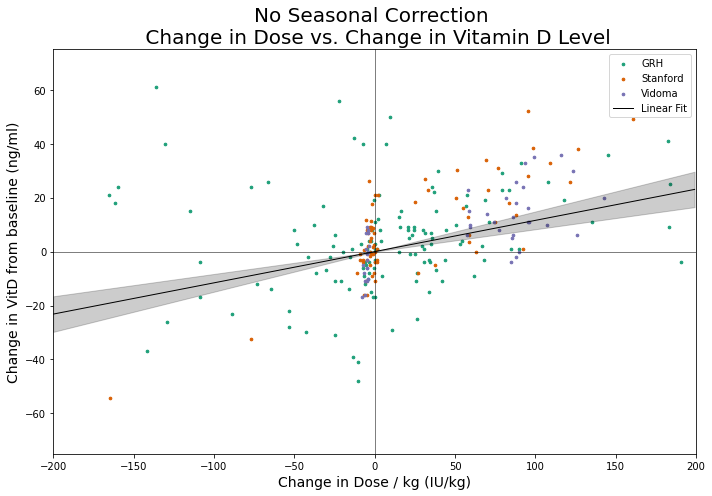

In [2527]:
plt.figure(figsize=[10,7])

plt.scatter(df_change1['change_dose'], df_change1['change_result'], label = 'GRH', s=7, color = colors[0])
plt.scatter(df_change2['change_dose'], df_change2['change_result'], label = 'Stanford', s=7, color = colors[1])
plt.scatter(df_change3['change_dose'], df_change3['change_result'], label = 'Vidoma', s=7, color = colors[2])

df_temp = df_change[(df_change.change_result < 75) & (df_change.change_dose < 200)]

#sns.regplot(x = df_temp['change_dose'], y = df_temp['change_result'],  ci=95, scatter=False, line_kws={'color':'black', 'linewidth': '1'}, label='Linear Fit')
x = np.arange(-200, 200, 1)
y = 0.1159 * x
y_low = (0.1159 - 0.0330) * x
y_high = (0.1159 + 0.0330) * x

plt.fill_between(x, y_low, y_high, color = 'black', alpha = 0.2)
plt.plot(x, y, color = 'black', linewidth = 1, label='Linear Fit')


plt.xlabel('Change in Dose / kg (IU/kg)', fontsize=14)
plt.ylabel('Change in VitD from baseline (ng/ml)', fontsize=14)
plt.title('No Seasonal Correction \n Change in Dose vs. Change in Vitamin D Level', fontsize=20)

plt.ylim([-75,75])
plt.xlim([-200,200])

plt.axhline(0, color='k', linewidth = 0.5)
plt.axvline(0, color='k', linewidth = 0.5)
plt.legend()

plt.tight_layout()
plt.savefig('Model1_linear_uncorrected.jpg')

In [314]:
df_temp = df_change.copy()
df_temp['resid'] = result.resid
df_temp['predicted'] = df_temp.change_result - df_temp.resid

In [315]:
df_temp.columns

Index(['index', 'ID', 'gender', 'result_baseline', 'result_baseline_corrected',
       'dose_baseline', 'result', 'result_corrected', 'dose', 'change_result',
       'change_result_corrected', 'change_dose', 'age', 'weight', 'height',
       'dataset', 'bmi', 'bmi_z_score', 'AGE', 'BMI', 'resid', 'predicted'],
      dtype='object')

Text(0.5, 1.0, 'Predicted vs. Residual')

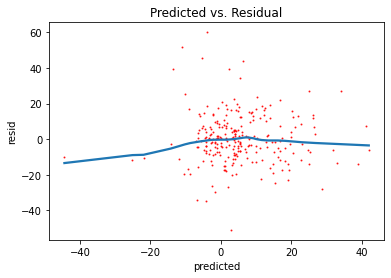

In [316]:
sns.regplot(x='predicted', y='resid', data=df_temp, lowess=True, scatter_kws={'color':'r', 's':1})
plt.title('Predicted vs. Residual')

Text(0.5, 1.0, 'Baseline VitD Level vs. Residual')

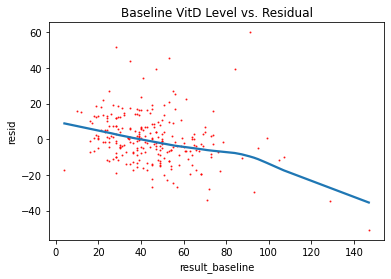

In [317]:
sns.regplot(x='result_baseline', y='resid', data=df_temp, lowess=True, scatter_kws={'color':'r', 's':1})
plt.title('Baseline VitD Level vs. Residual')

Text(0.5, 1.0, 'Baseline Dose vs. Residual')

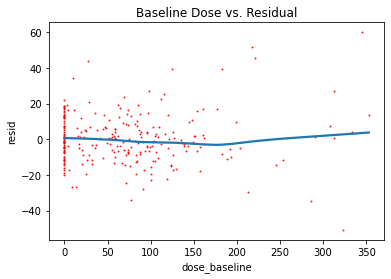

In [318]:
sns.regplot(x='dose_baseline', y='resid', data=df_temp, lowess=True, scatter_kws={'color':'r', 's':1})
plt.title('Baseline Dose vs. Residual')

Text(0.5, 1.0, 'Change in Dose vs. Residual')

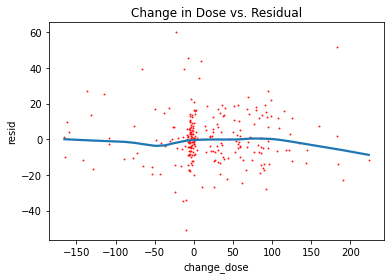

In [319]:
sns.regplot(x='change_dose', y='resid', data=df_temp, lowess=True, scatter_kws={'color':'r', 's':1})
plt.title('Change in Dose vs. Residual')

Text(0.5, 1.0, 'Age vs. Residual')

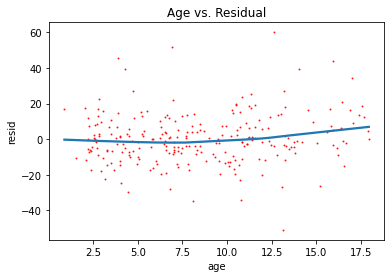

In [320]:
sns.regplot(x='age', y='resid', data=df_temp, lowess=True, scatter_kws={'color':'r', 's':1})
plt.title('Age vs. Residual')

Text(0.5, 1.0, 'BMI z-score vs. Residual')

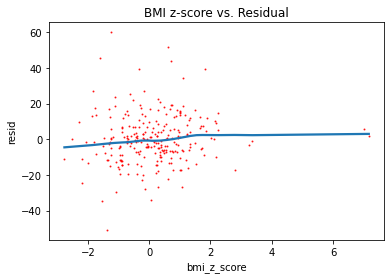

In [321]:
sns.regplot(x='bmi_z_score', y='resid', data=df_temp, lowess=True, scatter_kws={'color':'r', 's':1})
plt.title('BMI z-score vs. Residual')

In [322]:
df_temp.change_dose.max()

362.3809523809524

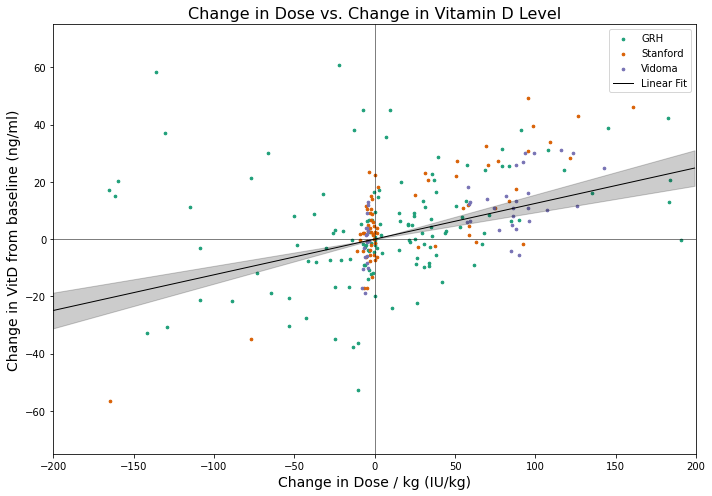

In [2546]:
plt.figure(figsize=[10,7])

plt.scatter(df_change1['change_dose'], df_change1['change_result_corrected'], label = 'GRH', s=7, color = colors[0])
plt.scatter(df_change2['change_dose'], df_change2['change_result_corrected'], label = 'Stanford', s=7, color = colors[1])
plt.scatter(df_change3['change_dose'], df_change3['change_result_corrected'], label = 'Vidoma', s=7, color = colors[2])

df_temp = df_change[(df_change.change_result < 75) & (df_change.change_dose < 200)]

#sns.regplot(x = df_temp['change_dose'], y = df_temp['change_result_corrected'],  ci=95, scatter=False, line_kws={'color':'black', 'linewidth': '1'}, label='Linear Fit')



x = np.arange(-200, 200, 1)
y = 0.1247 * x
y_low = (0.1247 - 0.0312) * x
y_high = (0.1247 + 0.0312) * x

plt.fill_between(x, y_low, y_high, color = 'black', alpha = 0.2)
plt.plot(x, y, color = 'black', linewidth = 1, label='Linear Fit')



plt.xlabel('Change in Dose / kg (IU/kg)', fontsize=14)
plt.ylabel('Change in VitD from baseline (ng/ml)', fontsize=14)
plt.title('Change in Dose vs. Change in Vitamin D Level', fontsize=16)

plt.ylim([-75,75])
plt.xlim([-200,200])

plt.axhline(0, color='k', linewidth = 0.5)
plt.axvline(0, color='k', linewidth = 0.5)
plt.legend()

plt.tight_layout()
#plt.savefig('Model1_linear.jpg')

In [323]:
#senstivitiy analysis looking at just baseline dose == 0

In [324]:
df_temp = df_change[(df_change.change_result < 75) & (df_change.change_dose < 250) & (df_change.dose_baseline == 0)].copy()


In [325]:
df_temp[['change_result_corrected', 'change_dose', 'result_baseline_corrected', 'dose_baseline', 'age', 'bmi_z_score']]

,change_result_corrected,change_dose,result_baseline_corrected,dose_baseline,age,bmi_z_score
0,20.600504,36.743710,16.599626,0.0,2.757016,-1.86
2,4.400464,34.994010,33.199611,0.0,9.563313,1.51
3,28.600539,39.368261,32.199611,0.0,2.047912,-0.28
4,25.424763,79.355556,18.200130,0.0,13.259411,0.48
8,-3.825097,15.384615,31.600075,0.0,8.555784,-0.36
...,...,...,...,...,...,...
246,24.849915,142.857143,37.774978,0.0,3.500000,0.71
247,15.150344,81.632653,29.624893,0.0,4.170000,3.27
249,6.200524,58.997050,28.599626,0.0,7.250000,1.32
251,-5.600000,89.686099,4.000000,0.0,3.670000,2.79


In [326]:
#md = smf.mixedlm('change_dose ~ 0 + change_result + C(dataset)', df_change, groups=df_change['ID'])
#mdf = md.fit()
#print(mdf.summary())

#df_temp = df_change[(df_change.change_result < 75) & (df_change.change_dose < 250)].copy()
df_temp = df_change[(df_change.change_result < 75) & (df_change.change_dose < 250) & (df_change.dose_baseline == 0)].copy()


g1 = "change_result_corrected ~ 0 + change_dose"
g2 = "change_result_corrected ~ 0 + change_dose + change_dose:result_baseline_corrected + change_dose:dose_baseline"
g3 = "change_result_corrected ~ 0 + change_dose + change_dose:result_baseline_corrected + change_dose:dose_baseline + change_dose:age + change_dose:bmi_z_score"


f1 = "change_result_corrected ~ 0 + change_dose"
f2 = "change_result_corrected ~ 0 + change_dose + change_dose:result_baseline_corrected + change_dose:dose_baseline"
f3 = "change_result_corrected ~ 0 + change_dose + change_dose:result_baseline_corrected + change_dose:AGE + change_dose:bmi_z_score"
ffinal = "change_result_corrected ~ 0 + change_dose + change_dose:result_baseline_corrected + change_dose:dose_baseline + change_dose:age"

df_temp['AGE'] = np.log(1 + df_temp.age/18)

ff = f3


sp1 = sm.OLS.from_formula(ff, data=df_temp).fit().summary2().tables[1]['Coef.']
 
model = sm.MixedLM.from_formula(ff, 
                               # vc_formula={"ID": "0 + C(ID)"},# "dataset": "0+C(dataset)"},
                                #re_formula="~1",
                                groups="ID",
                                data=df_temp)                                                   
result = model.fit(method='powell', reml=True)   #lbfgs, powell, cg, bfgs

result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
================================================================================
Model:                 MixedLM    Dependent Variable:    change_result_corrected
No. Observations:      62         Method:                REML                   
No. Groups:            61         Scale:                 73.7680                
Min. group size:       1          Log-Likelihood:        -247.5742              
Max. group size:       2          Converged:             Yes                    
Mean group size:       1.0                                                      
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
change_dose                            0.274    0.074  3.691 0.000  0.129  0.420
change_dose:result_baseline_corrected -0.001    0.002 -0.291 0.771 -0.005  0.004
change_dose:AGE                       -0.197    0.150 -1.311 0.190 -0.491  0.097
change_dose:bmi_z_score               -0.013    0.016 -0.793 0.428 -0.044  0.019
ID Var                                48.961   40.155                           
================================================================================

"""

In [327]:
np.round(result.params,4)

change_dose                              0.2744
change_dose:result_baseline_corrected   -0.0006
change_dose:AGE                         -0.1969
change_dose:bmi_z_score                 -0.0127
ID Var                                   0.6637
dtype: float64

In [328]:
np.round(1.96 * result.bse_fe,4)

change_dose                              0.1457
change_dose:result_baseline_corrected    0.0043
change_dose:AGE                          0.2943
change_dose:bmi_z_score                  0.0315
dtype: float64

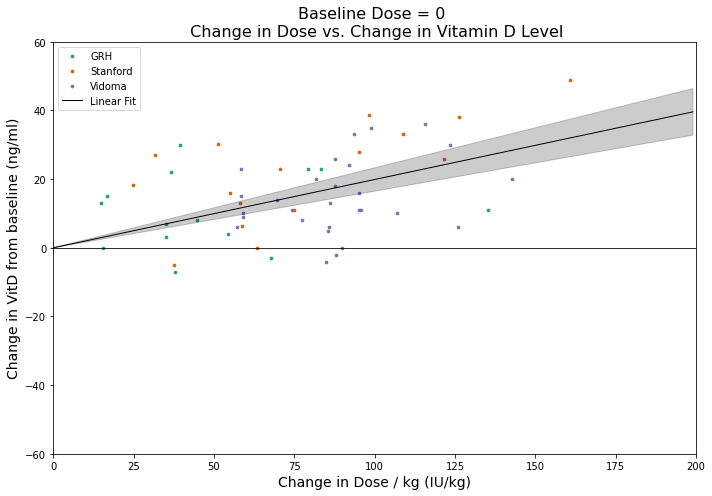

In [2553]:
plt.figure(figsize=[10,7])

plt.scatter(df_change1[(df_change1.dose_baseline==0) & (df_change1.dose > 0)]['change_dose'], df_change1[(df_change1.dose_baseline==0) & (df_change1.dose > 0)]['change_result'], label = 'GRH', s=7, color = colors[0])
plt.scatter(df_change2[df_change2.dose_baseline==0]['change_dose'], df_change2[df_change2.dose_baseline==0]['change_result'], label = 'Stanford', s=7, color = colors[1])
plt.scatter(df_change3[df_change3.dose_baseline==0]['change_dose'], df_change3[df_change3.dose_baseline==0]['change_result'], label = 'Vidoma', s=7, color = colors[2])

#sns.regplot(x = df_change[(df_change.dose_baseline==0) & (df_change.dose > 0)]['change_dose'], y = df_change[(df_change.dose_baseline==0) & (df_change.dose > 0)]['change_result'],  ci=95, scatter = False, line_kws={'color':'black', 'linewidth': '1'}, label='linear fit')

x = np.arange(-200, 200, 1)
y = 0.199 * x
y_low = (0.199 - 0.0341) * x
y_high = (0.199 + 0.0341) * x

plt.fill_between(x, y_low, y_high, color = 'black', alpha = 0.2)
plt.plot(x, y, color = 'black', linewidth = 1, label='Linear Fit')

plt.xlabel('Change in Dose / kg (IU/kg)', fontsize=14)
plt.ylabel('Change in VitD from baseline (ng/ml)', fontsize=14)
plt.title('Baseline Dose = 0 \n Change in Dose vs. Change in Vitamin D Level', fontsize=16)
plt.ylim([-60,60])
plt.xlim([0,200])
plt.axhline(0, color='k', linewidth = 0.8)
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('subset_analysis.jpg')

In [108]:
# model 2

In [108]:
df1_temp = df1.rename(columns={
    'dose/kg': 'dose',
    'd_result': 'result',
    'Age': 'age',
    'weight_kg': 'weight', 
    'height_current_cm': 'height', 
    'd_collect_month': 'month'})[['ID', 
    'gender',
    'dose',
    'result',
     'result_corrected',
     'age', 
    'weight', 
    'height',
    'month']]

df2_temp = df2.rename(columns={
    'suj_id': 'ID',
    'dose/kg': 'dose',
    'VitD_result': 'result',
    'Age at visit': 'age',
    'Month of visit': 'month'})[['ID', 
    'gender',
    'dose',
    'result',
     'result_corrected',
     'age', 
    'weight', 
    'height',
    'month']]

df3_temp = df3.rename(columns={
    'dose/kg': 'dose',
    'Result': 'result',
    'Age (years)': 'age',
    'Height (cm)': 'height',
    'Weight (kg)': 'weight',
    'Month_north': 'month'})[['ID', 
    'gender',
    'dose',
    'result',
     'result_corrected',
     'age', 
    'weight', 
    'height',
    'month']]



df1_temp['dataset'] = 'GRH'
df2_temp['dataset'] = 'Stanford'
df3_temp['dataset'] = 'Vidoma'
df= pd.concat([df1_temp, df2_temp, df3_temp])

df['ID'] = df['dataset'].str[0] + df['ID'].astype(str)

In [120]:
df = df[df.dose < 250]
#df = df[df.result_corrected <= 100]
df = df[~df.dose.isna()]
df = df[df.age < 18]

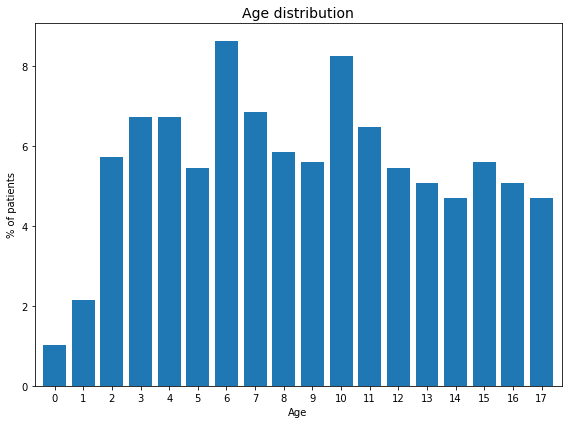

In [182]:
plt.figure(figsize=(8,6))

labels, counts = np.unique(np.floor(df.age), return_counts=True)
counts = counts * 100 / counts.sum()

plt.title('Age distribution', fontsize=14)
plt.bar(labels, counts,  align='center')
plt.gca().set_xticks(labels)
plt.xlabel('Age')
plt.ylabel('% of patients')
plt.xlim(-0.7,17.7)

plt.tight_layout()
plt.savefig('age_dist.jpg', dpi=400)

In [ ]:
labels, counts = np.unique(np.round(df.bmi_zscore), return_counts=True)
counts = counts * 100 / counts.sum()

plt.title('Age distribution', fontsize=14)
plt.bar(labels, counts,  align='center')
plt.gca().set_xticks(labels)
plt.xlabel('Age')
plt.ylabel('% of patients')
plt.xlim(-0.7,17.7)

In [111]:
grh_ids = df[df.dataset == 'GRH'].ID.str[1:].drop_duplicates()
stanford_ids = df[df.dataset == 'Stanford'].ID.str[1:].drop_duplicates()
vidoma_ids = df[df.dataset == 'Vidoma'].ID.str[1:].drop_duplicates()

In [159]:
#bmi
df['bmi'] = df.weight / ((df.height/100)**2)

In [160]:
from pygrowup import Calculator
calculator = Calculator(adjust_height_data=False, adjust_weight_scores=False,
                       include_cdc=True, logger_name='pygrowup',
                       log_level='INFO')

In [185]:
df.reset_index(inplace=True)
df = df.drop('index', axis=1)

def get_bmi_z_score(ii):
    bmi_val = df.iloc[ii]['bmi']
    age_val = df.iloc[ii]['age']
    gender_val = df.iloc[ii]['gender']
    
    if ii in df[df.bmi.isna()].index:
        return np.nan

    return float(calculator.bmifa(bmi_val, age_val * 12, gender_val))

df['bmi_z_score'] = df.index.map(get_bmi_z_score)


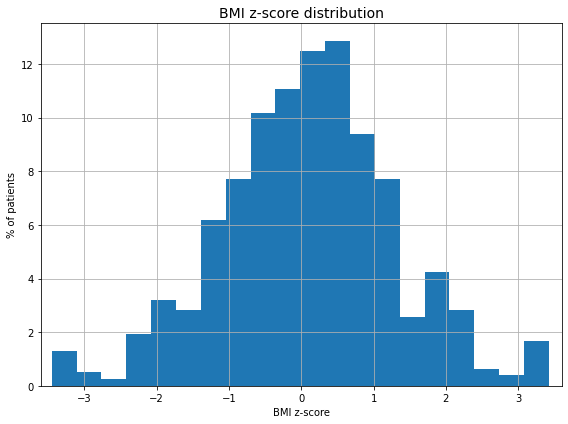

In [186]:
plt.figure(figsize=(8,6))

df[~df.bmi_z_score.isna()].bmi_z_score.clip(
    lower=np.percentile(df[~df.bmi_z_score.isna()].bmi_z_score, 1),
    upper=np.percentile(df[~df.bmi_z_score.isna()].bmi_z_score, 99)).hist(bins=20, weights = 100*np.ones(len(df[~df.bmi_z_score.isna()]))/len(df[~df.bmi_z_score.isna()]))


plt.title('BMI z-score distribution', fontsize=14)

plt.xlabel('BMI z-score')
plt.ylabel('% of patients')
plt.xlim(-3.6,3.6)

plt.tight_layout()
plt.savefig('bmi_dist.jpg', dpi=400)

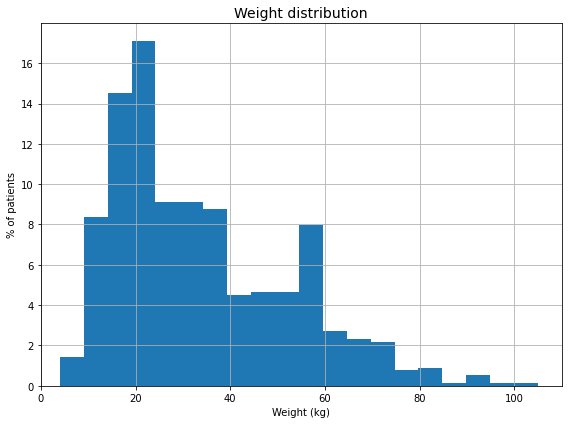

In [187]:
plt.figure(figsize=(8,6))

df[~df.weight.isna()].weight.hist(bins=20, weights = 100*np.ones(len(df[~df.weight.isna()]))/len(df[~df.weight.isna()]))

plt.title('Weight distribution', fontsize=14)

plt.xlabel('Weight (kg)')
plt.ylabel('% of patients')
plt.xlim(0,110)

plt.tight_layout()
plt.savefig('weight_dist.jpg', dpi=400)

In [116]:
df.bmi_z_score.mean()

0.09593307593307596

In [117]:
df.bmi_z_score.std()

1.3710444267993878

In [118]:
df.groupby('dataset').size()

dataset
GRH         624
Stanford     89
Vidoma       75
dtype: int64

In [119]:
df.groupby('dataset').ID.nunique()  / 4.51

dataset
GRH         89.356984
Stanford     4.212860
Vidoma       6.430155
Name: ID, dtype: float64

In [120]:
624 + 89 + 75

788

In [121]:
403 + 19 + 29

451

In [122]:
788/451

1.747228381374723

In [123]:
df.groupby('gender').ID.nunique() #/ 4.51

gender
F    209
M    243
Name: ID, dtype: int64

In [124]:
df.groupby('ID').age.min().describe()

count    451.000000
mean       9.639089
std        4.837363
min        0.076660
25%        5.342618
50%        9.648186
75%       13.854894
max       17.960301
Name: age, dtype: float64

In [125]:
df.columns

Index(['ID', 'gender', 'dose', 'result', 'result_corrected', 'age', 'weight',
       'height', 'month', 'dataset', 'bmi', 'bmi_z_score'],
      dtype='object')

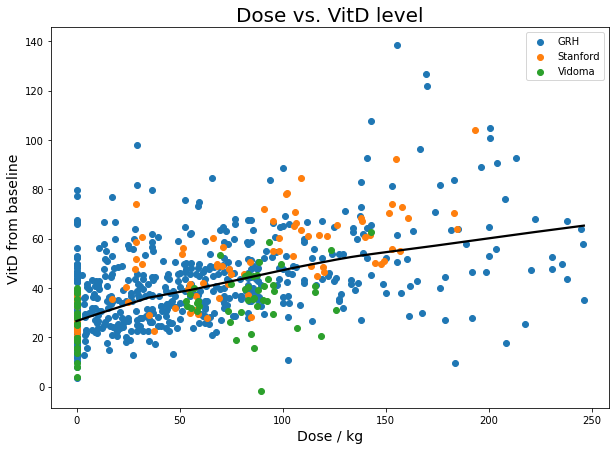

In [126]:
plt.figure(figsize=[10,7])

plt.scatter(df[df.dataset == 'GRH']['dose'],df[df.dataset == 'GRH']['result_corrected'], label = 'GRH')
plt.scatter(df[df.dataset == 'Stanford']['dose'],df[df.dataset == 'Stanford']['result_corrected'], label = 'Stanford')
plt.scatter(df[df.dataset == 'Vidoma']['dose'],df[df.dataset == 'Vidoma']['result_corrected'], label = 'Vidoma')

sns.regplot(x = df['dose'], y = df['result_corrected'], lowess = True, scatter_kws={'s':0}, line_kws={"color": "black"})

plt.xlabel('Dose / kg', fontsize=14)
plt.ylabel('VitD from baseline', fontsize=14)
plt.title('Dose vs. VitD level', fontsize=20)
#plt.ylim([-20,60])
#plt.axhline(0, color='k')
plt.legend()

Text(0.5, 1.0, 'Vitamin D levels for patients on supplements')

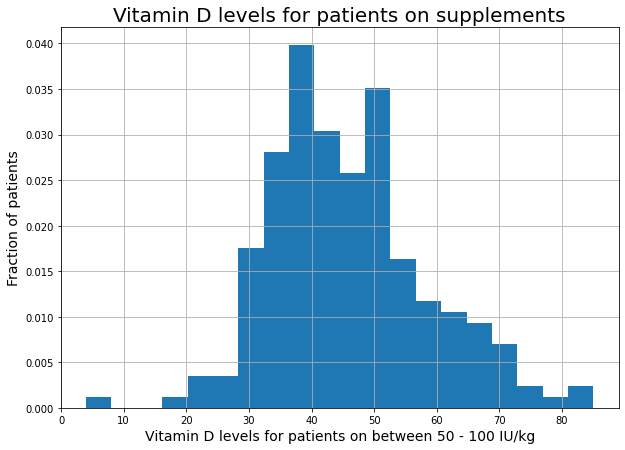

In [131]:
#poop
plt.figure(figsize=[10,7])

df[(df.dose > 50) & (df.dose < 100)].result.hist(bins=20, density=True)
plt.xlabel('Vitamin D levels for patients on between 50 - 100 IU/kg', fontsize=14)
plt.ylabel('Fraction of patients', fontsize=14)
plt.title('Vitamin D levels for patients on supplements', fontsize=20)

In [133]:
df[(df.dose > 50) & (df.dose < 100)].result.describe()

count    211.000000
mean      45.965877
std       12.387343
min        4.000000
25%       37.500000
50%       44.000000
75%       52.000000
max       85.000000
Name: result, dtype: float64

In [2572]:
df['log_dose'] = np.log(1 + df.dose)
df['dose_squared'] = df.dose**2

<AxesSubplot:>

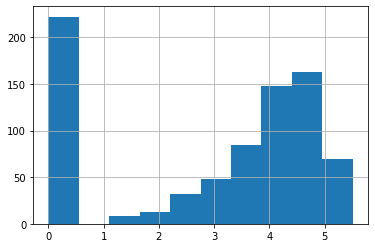

In [2573]:
df.log_dose.hist()

In [2574]:
df.dose.max()

246.09740895056103

In [2575]:
df.index

RangeIndex(start=0, stop=788, step=1)

In [2576]:
df.dropna(inplace=True)

<AxesSubplot:>

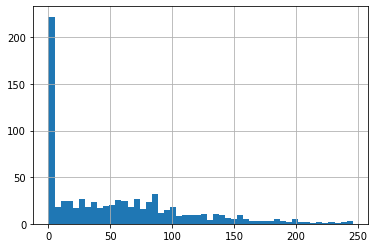

In [2596]:
df.dose.hist(bins=50)

<AxesSubplot:xlabel='age', ylabel='dose'>

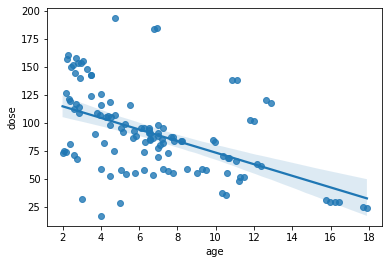

In [2602]:
#df_tt = df[(df.dose>25) & (df.dose<125) & (df.result_corrected<150)]
df_tt = df[(df.dose>0) & (df.dataset != 'GRH')]
x = df_tt.age
y = df_tt.dose #/ df_tt.dose
sns.regplot(x=x,y=y)

<AxesSubplot:xlabel='age', ylabel='change_dose'>

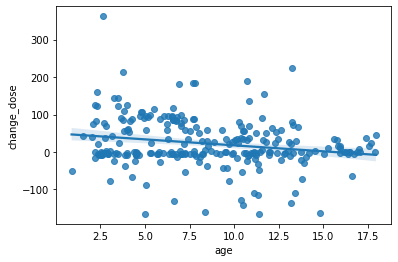

In [2600]:
#df_tt = df[(df.dose>25) & (df.dose<125) & (df.result_corrected<150)]
df_tt = df_change
x = df_tt.age
y = df_tt.change_dose #/ df_tt.dose
sns.regplot(x=x,y=y)

<AxesSubplot:xlabel='age', ylabel='result_corrected'>

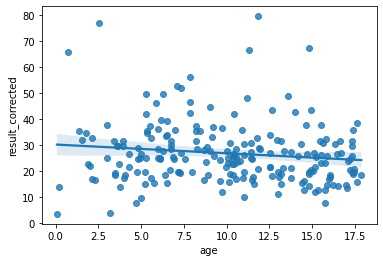

In [2580]:
#df_tt = df[(df.dose>25) & (df.dose<125) & (df.result_corrected<150)]
df_tt = df[df.dose < 1]
x = df_tt.age
y = df_tt.result_corrected #/ df_tt.dose
sns.regplot(x=x,y=y)

<AxesSubplot:xlabel='age', ylabel='result_corrected'>

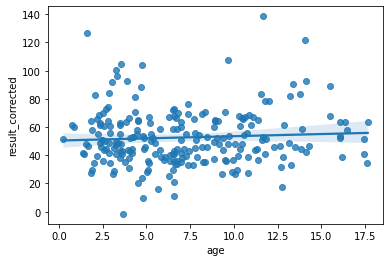

In [2581]:
#df_tt = df[(df.dose>25) & (df.dose<125) & (df.result_corrected<150)]
df_tt = df[df.dose > 80].reset_index()
x = df_tt.age
y = df_tt.result_corrected #/ df_tt.dose
sns.regplot(x=x,y=y)

In [2590]:
df_tt.sort_values(by='ratio')

,ID,gender,dose,result,result_corrected,age,weight,height,month,dataset,bmi,bmi_z_score,log_dose,dose_squared,Age,ratio
763,V28,M,89.686099,4.0,-1.600000,3.670000,22.300000,107.0,8,Vidoma,19.477684,2.79,4.507404,8043.596292,0-6,-0.017840
469,G395,M,183.718552,10.0,9.624893,4.815880,21.772434,117.0,3,GRH,15.905058,0.51,5.218833,33752.506283,0-6,0.052389
328,G330,M,208.312500,18.0,17.624893,12.752909,48.000000,160.0,1,GRH,18.750000,0.18,5.343828,43394.097656,7-12,0.084608
591,G421,M,102.540587,15.0,10.799700,6.570842,19.504472,119.0,10,GRH,13.773372,-1.58,4.639964,10514.571995,0-6,0.105321
364,G350,F,217.391304,28.0,25.200130,6.288843,23.000000,121.0,5,GRH,15.709309,0.29,5.386288,47258.979206,0-6,0.115921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,G262,F,10.214286,42.0,40.599626,12.725530,42.000000,155.0,12,GRH,17.481790,-0.41,2.417188,104.331633,7-12,3.974789
204,G225,F,13.222222,62.0,57.800150,14.488706,54.000000,165.0,6,GRH,19.834711,0.08,2.654806,174.827160,13-18,4.371440
498,G403,F,17.000000,81.0,76.799700,17.015743,63.000000,157.0,10,GRH,25.558846,1.10,2.890372,289.000000,13-18,4.517629
287,G309,F,13.222222,68.0,66.600075,16.470910,54.000000,168.0,4,GRH,19.132653,-0.56,2.654806,174.827160,13-18,5.036980


In [2592]:
df.groupby('dataset').result_corrected.mean()

dataset
GRH         39.379110
Stanford    49.351643
Vidoma      31.458361
Name: result_corrected, dtype: float64

In [2593]:
df.groupby('dataset').dose.mean()

dataset
GRH         52.839612
Stanford    76.632780
Vidoma      53.186576
Name: dose, dtype: float64

Text(0.5, 1.0, 'Ratio by age')

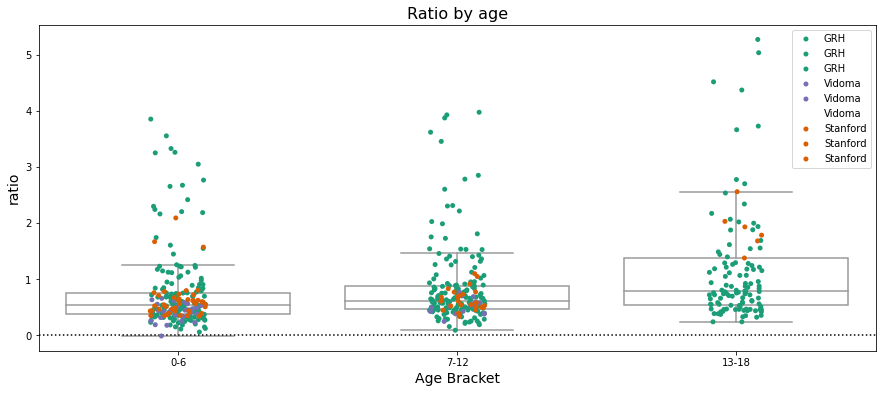

In [2589]:
df_tt = df[(df.dose > 10) ].copy()
df_tt['Age'] = np.floor(df_tt.age) 
df_tt['Age'] = '0-6'
df_tt.loc[df_tt.age >= 7, 'Age'] = '7-12'
df_tt.loc[df_tt.age >= 13, 'Age'] = '13-18'
df_tt['ratio'] = df.result_corrected / df.dose

order = ['0-6', '7-12', '13-18']


plt.figure(figsize=(15,6))
sns.boxplot(x='Age', y='ratio', data=df_tt, showfliers=False, color='white', order=order)
#sns.stripplot(x='Age', y='ratio', data=df_tt)
sns.stripplot(x='Age', y='ratio', data=df_tt[df_tt.dataset == 'GRH'], label = 'GRH', color = colors[0], order=order)
sns.stripplot(x='Age', y='ratio', data=df_tt[df_tt.dataset == 'Vidoma'], label = 'Vidoma', color = colors[2], order=order)
sns.stripplot(x='Age', y='ratio', data=df_tt[df_tt.dataset == 'Stanford'], label = 'Stanford', color = colors[1], order=order)

plt.legend()
plt.axhline(0, color='k', linestyle = ':')

plt.xlabel('Age Bracket', fontsize=14)
plt.ylabel('ratio', fontsize=14)
plt.title('Ratio by age', size=16)

dose    0.503833
dtype: float64

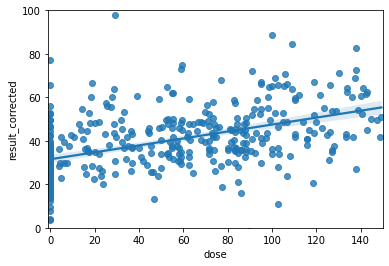

In [2439]:
dmax = 150
rmax = 100
df_tt = df[(df.age<10) & (df.result_corrected < rmax) & (df.dose < dmax)].reset_index()
x = df_tt.dose
y = df_tt.result_corrected #/ df_tt.dose
sns.regplot(x=x,y=y)
plt.ylim([0,rmax])
plt.xlim([-1,dmax])
fit_results = sm.OLS(y, x).fit()
fit_results.params

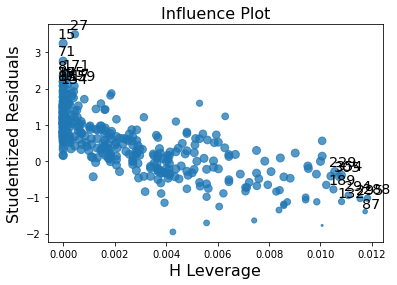

In [2443]:
sm.graphics.influence_plot(fit_results, size=2,alpha  = 0.05, criterion="cooks");

In [2449]:
df_tt.iloc[15]

index                    25
ID                      G27
gender                    F
dose                      0
result                   28
result_corrected    27.6249
age                 13.3525
weight                   43
height                  163
month                     1
dataset                 GRH
bmi                 16.1843
bmi_z_score           -1.22
log_dose                  0
dose_squared              0
Name: 15, dtype: object

dose    0.608553
dtype: float64

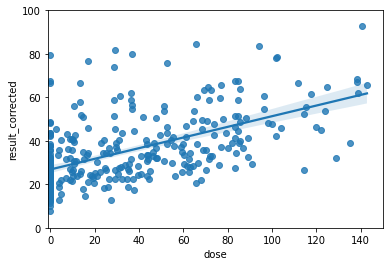

In [2450]:
df_tt = df[(df.age>=10) & (df.result_corrected < rmax) & (df.dose < dmax)].reset_index()
x = df_tt.dose
y = df_tt.result_corrected #/ df_tt.dose
sns.regplot(x=x,y=y)
plt.ylim([0,rmax])
plt.xlim([-1,dmax])
fit_results = sm.OLS(y, x).fit()
fit_results.params

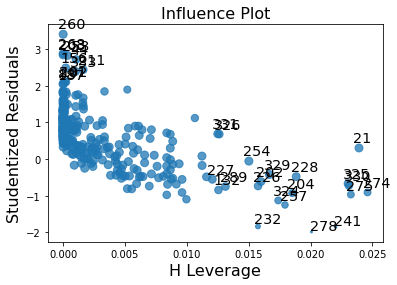

In [2451]:
sm.graphics.influence_plot(fit_results, size=2,alpha  = 0.05, criterion="cooks");

In [2452]:
df_tt.iloc[260]

index                   513
ID                     G407
gender                    M
dose                      0
result                   80
result_corrected    79.6249
age                 11.8604
weight                   50
height                  160
month                     3
dataset                 GRH
bmi                 19.5312
bmi_z_score            0.67
log_dose                  0
dose_squared              0
Name: 260, dtype: object

<AxesSubplot:>

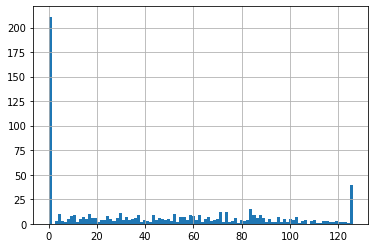

In [2457]:
df_temp.dose.hist(bins=100)

In [2762]:
df_temp = df[(df.dose<75)].reset_index()
#df_temp.dose = df_temp.dose.clip(lower = np.percentile(df_temp.dose,1),
#                                 upper = np.percentile(df_temp.dose,99))
df_temp.result_corrected = df_temp.result_corrected.clip(lower = np.percentile(df_temp.result_corrected,5),
                                 upper = np.percentile(df_temp.result_corrected,95))

f1 = "result_corrected ~ log_dose"
f2 = "result_corrected ~ log_dose + age + bmi_z_score + age + log_dose:age"
f3 = "result_corrected ~ log_dose + age + bmi_z_score + log_dose:age + log_dose:bmi_z_score"

g1 = "result_corrected ~ dose"
g2 = "result_corrected ~ dose + dose:age + dose:bmi_z_score"
g3 = "result_corrected ~ dose + log_dose + dose:age + dose:bmi_z_score"


ff = g2


#sp1 = sm.OLS.from_formula(ff, data=df).fit().summary2().tables[1]['Coef.']
 



model = sm.MixedLM.from_formula(ff, 
                                vc_formula={"ID": "0 + C(ID)"},# "dataset": "0+C(dataset)"},
                                re_formula="~1",
                                groups="dataset",
                                data=df_temp)                                                   
result = model.fit(method='powell', reml=True)   #lbfgs, powell, cg, bfgs

result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: result_corrected
No. Observations: 531     Method:             REML            
No. Groups:       3       Scale:              66.6999         
Min. group size:  41      Log-Likelihood:     -2011.1892      
Max. group size:  443     Converged:          Yes             
Mean group size:  177.0                                       
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           27.782    1.884 14.748 0.000 24.090 31.474
dose                 0.263    0.035  7.494 0.000  0.194  0.332
dose:age            -0.006    0.003 -1.950 0.051 -0.013  0.000
dose:bmi_z_score    -0.002    0.009 -0.219 0.827 -0.020  0.016
dataset Var          7.525    1.319                           
ID Var              52.273    1.541                           
==============================================================

"""

In [2763]:
.06/.26

0.23076923076923075

In [2207]:
x = [float(i) for i in range(400)]
y = [29.105 + 0.197 * i + 0 * np.log(.1 + i) for i in range(400)]


Text(0.5, 1.0, 'Dose/kg')

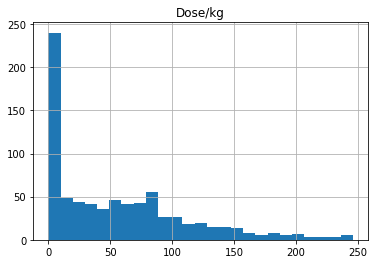

In [2208]:
df.dose.hist(bins=25)
plt.title('Dose/kg')

Text(0.5, 1.0, 'VitD Level')

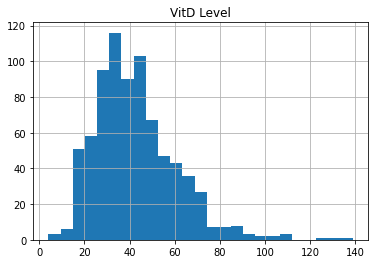

In [2209]:
df.result.hist(bins=25)
plt.title('VitD Level')

<AxesSubplot:>

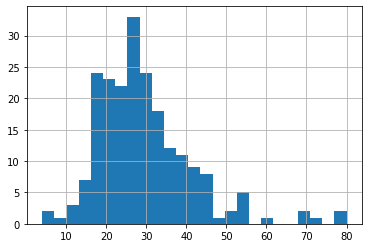

In [2210]:
df[df.dose==0].result.hist(bins=25)

In [2211]:
df[df.dose==0].result.mean()

29.69328925592417

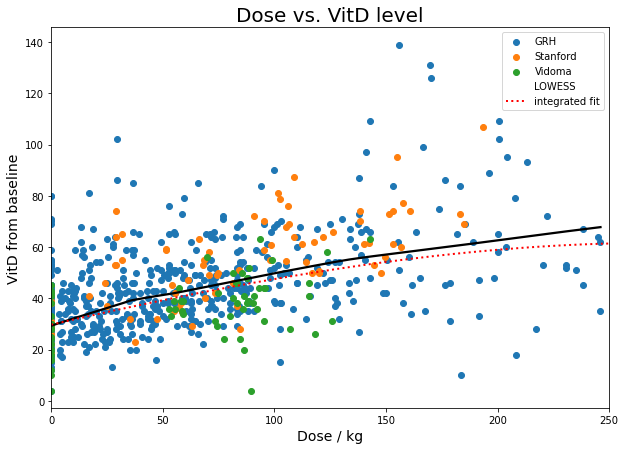

In [2679]:
plt.figure(figsize=[10,7])

plt.scatter(df[df.dataset == 'GRH']['dose'],df[df.dataset == 'GRH']['result'], label = 'GRH')
plt.scatter(df[df.dataset == 'Stanford']['dose'],df[df.dataset == 'Stanford']['result'], label = 'Stanford')
plt.scatter(df[df.dataset == 'Vidoma']['dose'],df[df.dataset == 'Vidoma']['result'], label = 'Vidoma')

sns.regplot(x = df['dose'], y = df['result'], lowess = True, scatter_kws={'s':0}, line_kws={"color": "black"}, label='LOWESS')

bb_temp = 1 * bb

c1 = df[df.dose==0].result.mean() + (aa  * cc +  bb_temp ) / cc**2

x = [float(i) for i in range(400)]
y = [-(aa * cc + bb_temp ) / cc**2 - bb_temp/cc * i + c1 * np.exp(cc * i) for i in range(400)]

plt.plot(x,y, 'r:',linewidth = 2, label='integrated fit')

plt.xlabel('Dose / kg', fontsize=14)
plt.ylabel('VitD from baseline', fontsize=14)
plt.title('Dose vs. VitD level', fontsize=20)

plt.xlim([0,250])
#plt.ylim([-20,60])
#plt.axhline(0, color='k')
plt.legend()

In [2680]:
from patsy import dmatrix
#transformed_x = dmatrix("bs(train, knots=(66,133,60), degree=2, include_intercept=False)",
#                        {"train": df['dose']},return_type='dataframe')



transformed_x = dmatrix("cr(df.dose, df=3)", {"df.dose": df.dose}, return_type='dataframe')

df_temp = pd.concat([df, transformed_x],axis=1).rename(columns={'cr(df.dose, df=3)[0]':'comp_1',
                                                     'cr(df.dose, df=3)[1]':'comp_2',
                                                     'cr(df.dose, df=3)[2]':'comp_3'}).copy()

In [2681]:
df_temp[['result_corrected', 'comp_1', 'comp_2', 'comp_3']]

,result_corrected,comp_1,comp_2,comp_3
0,35.624893,1.000000,0.000000,0.000000
1,21.000000,0.706893,0.304609,-0.011502
2,30.775237,1.000000,0.000000,0.000000
3,38.799700,-0.205973,1.158244,0.047728
4,29.799700,1.000000,0.000000,0.000000
...,...,...,...,...
783,31.800150,0.114192,0.896652,-0.010844
784,15.800150,-0.200339,1.154729,0.045610
785,20.400000,-0.364032,1.199706,0.164326
786,41.624893,-0.103879,1.086072,0.017807


In [2682]:
df_temp.comp_1+df_temp.comp_2 + df_temp.comp_3

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
783    1.0
784    1.0
785    1.0
786    1.0
787    1.0
Length: 777, dtype: float64

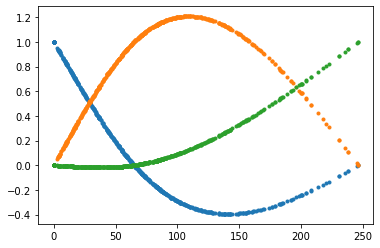

In [2716]:
plt.plot(df_temp.dose, df_temp.comp_1,'.')
plt.plot(df_temp.dose, df_temp.comp_2,'.')
plt.plot(df_temp.dose, df_temp.comp_3,'.')

In [2717]:

g1 = "result_corrected ~ 0 + comp_1 + comp_2 + comp_3"
#g2 = "result_corrected ~ dose + age + dose:age"
g2 = "result_corrected ~ 0 + comp_1 + comp_2 + (comp_1 + comp_2 + comp_3):age + (comp_1 + comp_2 + comp_3):bmi_z_score"
g3 = "result_corrected ~ 0 + comp_1 + comp_2 + comp_3 + age + bmi_z_score + dose:age + dose:bmi_z_score"

ff= g1

model = sm.MixedLM.from_formula(ff, 
                                vc_formula={"ID": "0 + C(ID)"},# "dataset": "0+C(dataset)"},
                                re_formula="~1",
                                groups="dataset",
                                data=df_temp)                                                   
result = model.fit(method='powell', reml=True)   #lbfgs, powell, cg, bfgs

result.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: result_corrected
No. Observations: 777     Method:             REML            
No. Groups:       3       Scale:              137.6590        
Min. group size:  74      Log-Likelihood:     -3150.8993      
Max. group size:  614     Converged:          Yes             
Mean group size:  259.0                                       
---------------------------------------------------------------
                Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------------
comp_1          27.657     3.888   7.113  0.000  20.036  35.278
comp_2          42.064     3.850  10.926  0.000  34.518  49.609
comp_3          64.837     5.033  12.883  0.000  54.973  74.701
dataset Var     40.392     3.869                               
ID Var          75.737     1.384                               
==============================================================

"""

In [2736]:
np.round(result.params,4)

comp_1         27.6569
comp_2         42.0636
comp_3         64.8367
dataset Var     0.2934
ID Var          0.5502
dtype: float64

In [2746]:
np.round(1.96 * result.bse_fe,4)

comp_1    7.6209
comp_2    7.5459
comp_3    9.8643
dtype: float64

In [2710]:
df_tt = df_temp.copy()
df_tt['resid'] = result.resid
df_tt['predicted'] = df_tt.result_corrected - df_tt.resid

Text(0.5, 1.0, 'Predicted vs. Residual')

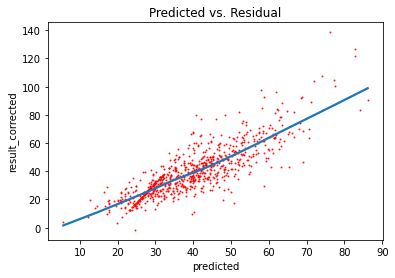

In [2711]:
sns.regplot(x='predicted', y='result_corrected', data=df_tt, lowess=True, scatter_kws={'color':'r', 's':1})
plt.title('Predicted vs. Residual')

Text(0.5, 1.0, 'Change in Dose vs. Residual')

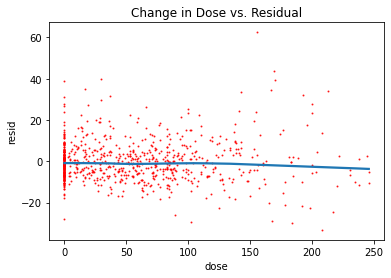

In [2712]:
sns.regplot(x='dose', y='resid', data=df_tt, lowess=True, scatter_kws={'color':'r', 's':1})
plt.title('Change in Dose vs. Residual')

Text(0.5, 1.0, 'BMI z-score vs. Residual')

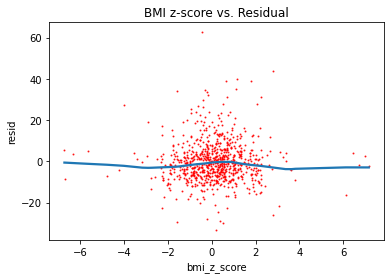

In [2713]:
sns.regplot(x='bmi_z_score', y='resid', data=df_tt, lowess=True, scatter_kws={'color':'r', 's':1})
plt.title('BMI z-score vs. Residual')

In [2752]:
ff= g1

model = sm.MixedLM.from_formula(ff, 
                                vc_formula={"ID": "0 + C(ID)"},# "dataset": "0+C(dataset)"},
                                re_formula="~1",
                                groups="dataset",
                                data=df_temp)                                                   
result = model.fit(method='powell', reml=True)   #lbfgs, powell, cg, bfgs

df_pred = df_temp[['dose']].copy()
df_pred['pred'] = (df_temp[['comp_1', 'comp_2', 'comp_3']]* result.params[:3]).sum(axis=1)
df_pred['err'] = ((df_temp[['comp_1', 'comp_2', 'comp_3']] * 1.96 * result.bse_fe) ** 2).sum(axis=1)**0.5
df_pred.sort_values(by='dose', inplace=True)
df_pred.drop_duplicates(inplace=True)

In [2757]:
(df_temp[['comp_1', 'comp_2', 'comp_3']] * 1.96 * result.bse_fe) ** 2

,comp_1,comp_2,comp_3
0,58.077395,0.000000,0.000000
1,29.021166,5.283255,0.012873
2,58.077395,0.000000,0.000000
3,2.463919,76.386545,0.221659
4,58.077395,0.000000,0.000000
...,...,...,...
783,0.757314,45.778806,0.011441
784,2.330973,75.923560,0.202418
785,7.696375,81.953260,2.627494
786,0.626702,67.163585,0.030853


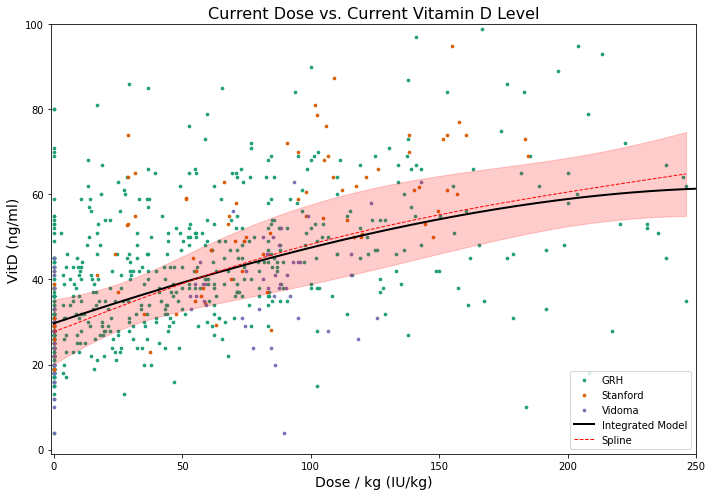

In [2760]:
plt.figure(figsize=[10,7])

plt.scatter(df[df.dataset == 'GRH']['dose'],df[df.dataset == 'GRH']['result'], label = 'GRH', s=7, color = colors[0])
plt.scatter(df[df.dataset == 'Stanford']['dose'],df[df.dataset == 'Stanford']['result'], label = 'Stanford', s=7, color = colors[1])
plt.scatter(df[df.dataset == 'Vidoma']['dose'],df[df.dataset == 'Vidoma']['result'], label = 'Vidoma', s=7, color = colors[2])

#sns.regplot(x = df['dose'], y = df['result'], lowess = True, scatter_kws={'s':0}, line_kws={"color": "black"}, label='LOWESS')


c1 = df[df.dose==0].result.mean() + (aa  * cc + bb ) / cc**2

x = [float(i) for i in range(400)]
y = [-(aa * cc + bb ) / cc**2 - bb/cc * i + c1 * np.exp(cc * i)  for i in range(400)]

plt.plot(x,y, 'k',linewidth = 2, label='Integrated Model')



df_tt.sort_values(by='dose', inplace=True)
plt.plot(df_pred.dose, df_pred.pred, label='Spline', linewidth = 1, color ='red', linestyle='--')

plt.fill_between(df_pred.dose, df_pred.pred-df_pred.err, df_pred.pred+df_pred.err, color = 'r', alpha = 0.2)
#plt.fill_between(x, y_low, y_high, color = 'black', alpha = 0.2)

#x = [float(i) for i in range(400)]
#y = [29.105 + 0.197 * i + 0 * np.log(.1 + i) for i in range(400)]

#plt.plot(x,y, 'g:',linewidth = 1, label='Linear fit')

plt.xlabel('Dose / kg (IU/kg)', fontsize=14)
plt.ylabel('VitD (ng/ml)', fontsize=14)
plt.title('Current Dose vs. Current Vitamin D Level', fontsize=16)

plt.xlim([-1,250])
plt.ylim([-1,100])
#plt.axhline(0, color='k')
plt.legend()
plt.tight_layout()

plt.savefig('model2.jpg', dpi=200)

In [108]:
# de-seasonalize

In [1951]:
df.columns

Index(['ID', 'gender', 'dose', 'result', 'result_corrected', 'age', 'weight',
       'height', 'month', 'dataset', 'bmi', 'bmi_z_score', 'log_dose',
       'dose_squared'],
      dtype='object')

In [1978]:
df.dose.describe()

count    777.000000
mean      55.598000
std       56.475586
min        0.000000
25%        0.000000
50%       44.086420
75%       86.956522
max      246.097409
Name: dose, dtype: float64

In [1979]:
df.result.describe()

count    777.000000
mean      42.451588
std       18.055678
min        4.000000
25%       29.300000
50%       39.000000
75%       52.000000
max      139.000000
Name: result, dtype: float64

In [1981]:
df = df[df.result<120]

Text(0.5, 1.0, 'Result by collection Month')

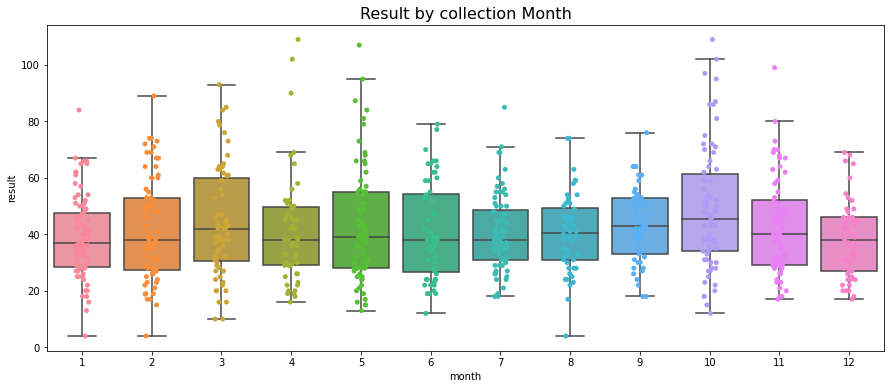

In [1982]:
plt.figure(figsize=(15,6))
sns.boxplot(x='month', y='result', data=df, showfliers=False)
sns.stripplot(x='month', y='result', data=df)
plt.title('Result by collection Month', size=16)

Text(0.5, 1.0, 'Result by collection Month')

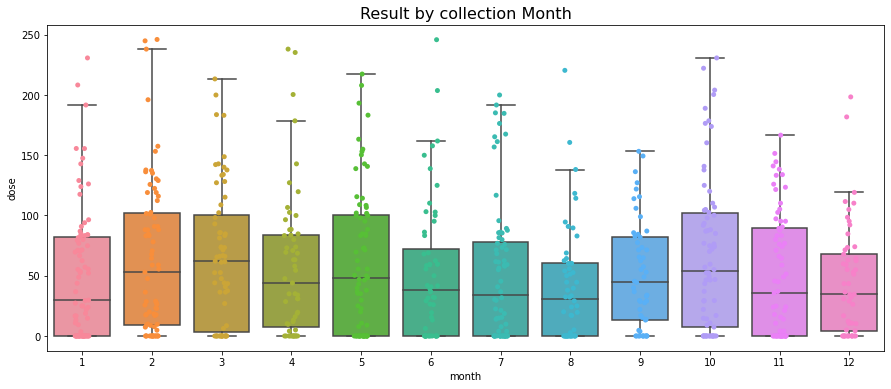

In [1983]:
plt.figure(figsize=(15,6))
sns.boxplot(x='month', y='dose', data=df, showfliers=False)
sns.stripplot(x='month', y='dose', data=df)
plt.title('Result by collection Month', size=16)

In [1984]:
df['cos_t'] = np.cos(2*3.1415 / 12 * (df.month - 1))
df['sin_t'] = np.sin(2*3.1415 / 12 * (df.month - 1))

In [1985]:
# first do dose by time

In [1986]:
features = ['cos_t', 'sin_t']
X = sm.add_constant(df[features])

y = np.array(df['dose'].fillna(0))

est = sm.OLS(y.astype(float), X.astype(float)).fit() 
est.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.001    
Dependent Variable: y                AIC:                8434.4692
Date:               2022-08-24 11:47 BIC:                8448.4240
No. Observations:   774              Log-Likelihood:     -4214.2  
Df Model:           2                F-statistic:        1.479    
Df Residuals:       771              Prob (F-statistic): 0.229    
R-squared:          0.004            Scale:              3151.1   
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const      55.0342     2.0213   27.2269   0.0000   51.0663   59.0021
cos_t       1.9705     2.8238    0.6978   0.4855   -3.5727    7.5137
sin_t       4.5620     2.8898    1.5787   0.1148   -1.1108   10.2347
------------------------------------------------------------------
Omnibus:             106.664       Durbin-Watson:          1.320  
Prob(Omnibus):       0.000         Jarque-Bera (JB):       149.311
Skew:                1.035         Prob(JB):               0.000  
Kurtosis:            3.590         Condition No.:          1      
==================================================================

"""

In [1987]:
c = est.summary2().tables[1].loc['cos_t','Coef.']
s = est.summary2().tables[1].loc['sin_t','Coef.']
intercept = est.summary2().tables[1].loc['const','Coef.'] 

2 * (c**2 + s**2)**0.5

9.938734654331956

In [1988]:
dc = est.summary2().tables[1].loc['cos_t','Std.Err.']
ds = est.summary2().tables[1].loc['sin_t','Std.Err.']

1.96*(4*c**2*dc**2 / (c**2 + s**2) + 4*s**2*ds**2 / (c**2 + s**2)) ** (1/2)

11.28760736252327

In [1989]:
-np.arctan(-s/ c) * 12/(2*3.1415)

2.22133769434345

In [1990]:
-s/c

-2.315093379913593

In [1991]:
df_temp = df[['month', 'cos_t', 'sin_t']].drop_duplicates().sort_values(by='month').reset_index().copy()
df_temp['dose_fit'] =  c * df_temp.cos_t + s * df_temp.sin_t  + intercept

In [1992]:
df_temp

,index,month,cos_t,sin_t,dose_fit
0,0,1,1.000000,0.000000,57.004745
1,1,2,0.866033,0.499987,59.021684
2,10,3,0.500027,0.866010,59.970244
3,14,4,0.000046,1.000000,59.596274
4,52,5,-0.499947,0.866056,57.999973
5,11,6,-0.865987,0.500067,55.609043
6,2,7,-1.000000,0.000093,53.064097
7,6,8,-0.866079,-0.499906,51.047009
8,5,9,-0.500107,-0.865964,50.098228
9,3,10,-0.000139,-1.000000,50.471962


In [1993]:
colors = ['#1b9e77', '#d95f02', '#7570b3']

In [1994]:
df_temp['month_minus_one'] = df_temp.month - 1

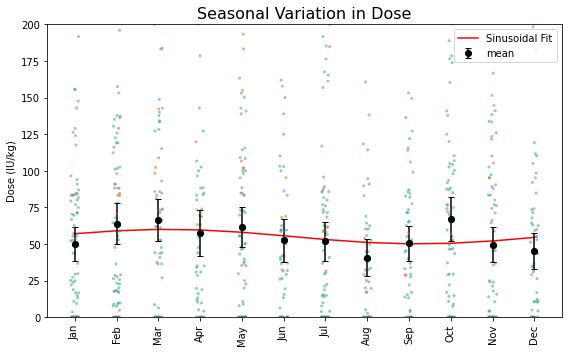

In [1995]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

err = [1.96 * (df.groupby('month').dose.sem()).values,
 1.96 * (df.groupby('month').dose.sem()).values]

plt.scatter(x = df.groupby('month').result.mean().index - 1, y = df.groupby('month').dose.mean() )
plt.errorbar(df.groupby('month').result.mean().index - 1, df.groupby('month').dose.mean(), yerr=err,
             fmt="o", color='black', label='mean', capsize=3)


ii = 0
for pp in set(df.dataset):
    df_dd = df[df.dataset==pp].copy()
    #plt.scatter(df_temp.Sample_Type , df_temp['Firmicutes'], s=3, alpha=0.5)
    sns.stripplot(x=df_dd['month'] , y='dose', data=df_dd, 
                  order = [1,2,3,4,5,6,7,8,9,10,11,12],
                  s=3, alpha=0.5, color = colors[ii], zorder = 1 + ii, ax=ax)
    ii += 1


df_temp.plot(x = 'month_minus_one', y = 'dose_fit', style = 'r-', ax=ax, label = 'Sinusoidal Fit', zorder=0)

labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
labels_pos = [0,1,2,3,4,5,6,7,8,9,10,11]
plt.xticks(labels_pos, labels, rotation='vertical')

plt.legend(loc='upper right')

plt.ylabel('Dose (IU/kg)')
plt.xlabel('')
plt.title('Seasonal Variation in Dose', fontsize=16)

#ax.set_yscale('log')
plt.ylim([0,200])

plt.tight_layout()
plt.savefig('Seaonal_Var_Dose.jpg', dpi=400)

In [1996]:
# then do result by time

In [1997]:
X.isna().sum()

const    0
cos_t    0
sin_t    0
dtype: int64

In [1998]:
features = [ 'cos_t', 'sin_t', 'dose']
X = sm.add_constant(df[features])

y = np.array(df['result'].fillna(0))

est = sm.OLS(y.astype(float), X.astype(float)).fit() 
est.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.311    
Dependent Variable: y                AIC:                6316.7157
Date:               2022-08-24 11:47 BIC:                6335.3220
No. Observations:   774              Log-Likelihood:     -3154.4  
Df Model:           3                F-statistic:        117.1    
Df Residuals:       770              Prob (F-statistic): 1.77e-62 
R-squared:          0.313            Scale:              204.00   
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const      32.7101     0.7203   45.4123   0.0000   31.2961   34.1240
cos_t      -0.7907     0.7187   -1.1002   0.2716   -2.2016    0.6201
sin_t      -1.7237     0.7365   -2.3406   0.0195   -3.1694   -0.2780
dose        0.1713     0.0092   18.6896   0.0000    0.1533    0.1892
------------------------------------------------------------------
Omnibus:              75.504       Durbin-Watson:          1.628  
Prob(Omnibus):        0.000        Jarque-Bera (JB):       134.488
Skew:                 0.637        Prob(JB):               0.000  
Kurtosis:             4.597        Condition No.:          114    
==================================================================

"""

In [1999]:
c = est.summary2().tables[1].loc['cos_t','Coef.']
s = est.summary2().tables[1].loc['sin_t','Coef.']
intercept = est.summary2().tables[1].loc['const','Coef.'] 
dose_factor = est.summary2().tables[1].loc['dose','Coef.'] 

2 * (c**2 + s**2)**0.5

3.7929078691459317

In [2000]:
dc = est.summary2().tables[1].loc['cos_t','Std.Err.']
ds = est.summary2().tables[1].loc['sin_t','Std.Err.']

1.96*(4*c**2*dc**2 / (c**2 + s**2) + 4*s**2*ds**2 / (c**2 + s**2)) ** (1/2)

2.8749158236554013

In [2001]:
np.arctan(c/ s) * 12/(2*3.1415)

0.8214433463348156

In [2002]:
#df_temp = df[['month', 'cos_t', 'sin_t']].drop_duplicates().sort_values(by='month').reset_index().copy()
df_temp['result_fit'] =  c * df_temp.cos_t + s * df_temp.sin_t  + intercept + dose_factor * df_temp.dose_fit
df_temp['result_resid_fit'] =  c * df_temp.cos_t + s * df_temp.sin_t  + intercept 

In [2003]:
df_temp[['month', 'result_fit']]

,month,result_fit
0,1,41.681899
1,2,41.271405
2,3,41.092342
3,4,41.192686
4,5,41.545553
5,6,42.056396
6,7,42.588345
7,8,42.998871
8,9,43.177982
9,10,43.077687


In [2004]:
df_temp['correction'] = - 3.5 + 3.5 * np.cos((df_temp.month - 2) /6 *3.1415 )
df_temp

,index,month,cos_t,sin_t,dose_fit,month_minus_one,result_fit,result_resid_fit,correction
0,0,1,1.000000,0.000000,57.004745,0,41.681899,31.919326,-0.468884
1,1,2,0.866033,0.499987,59.021684,1,41.271405,31.163413,0.000000
2,10,3,0.500027,0.866010,59.970244,2,41.092342,30.821900,-0.468884
3,14,4,0.000046,1.000000,59.596274,3,41.192686,30.986291,-1.749906
4,52,5,-0.499947,0.866056,57.999973,4,41.545553,31.612538,-3.499838
5,11,6,-0.865987,0.500067,55.609043,5,42.056396,32.532850,-5.249813
6,2,7,-1.000000,0.000093,53.064097,6,42.588345,33.500643,-6.530954
7,6,8,-0.866079,-0.499906,51.047009,7,42.998871,34.256614,-7.000000
8,5,9,-0.500107,-0.865964,50.098228,8,43.177982,34.598212,-6.531278
9,3,10,-0.000139,-1.000000,50.471962,9,43.077687,34.433912,-5.250374


In [2005]:
err = [(df.groupby('month').result.mean() - df.groupby('month').result.sem()).values,
 (df.groupby('month').result.mean() + df.groupby('month').result.sem()).values]

(0.0, 120.0)

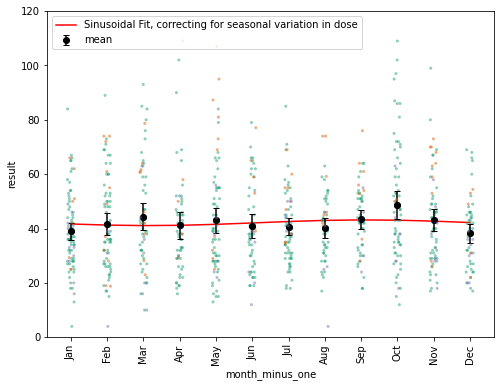

In [2006]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

err = [1.96*(df.groupby('month').result.sem()).values,
 1.96*(df.groupby('month').result.sem()).values]

plt.scatter(x = df.groupby('month').result.mean().index - 1, y = df.groupby('month').result.mean() )
plt.errorbar(df.groupby('month').result.mean().index - 1, df.groupby('month').result.mean(), yerr=err,
             fmt="o", color='black', label='mean', capsize=3)


ii = 0
for pp in set(df.dataset):
    df_dd = df[df.dataset==pp].copy()
    #plt.scatter(df_temp.Sample_Type , df_temp['Firmicutes'], s=3, alpha=0.5)
    sns.stripplot(x=df_dd['month'] , y='result', data=df_dd, 
                  order = [1,2,3,4,5,6,7,8,9,10,11,12],
                  s=3, alpha=0.5, color = colors[ii], zorder = 1 + ii, ax=ax)
    ii += 1


df_temp.plot(x = 'month_minus_one', y = 'result_fit', style = 'r-', ax=ax, label = 'Sinusoidal Fit, correcting for seasonal variation in dose', zorder=0)

labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
labels_pos = [0,1,2,3,4,5,6,7,8,9,10,11]
plt.xticks(labels_pos, labels, rotation='vertical')

plt.legend()
plt.ylim([0,120])

#ax.set_yscale('log')

In [2007]:
df['result_resid'] = df['result'] - dose_factor * df['dose']

In [2008]:
df[['dose', 'result', 'result_resid']].sort_values(by='result_resid')

,dose,result,result_resid
469,183.718552,10.0,-21.463447
328,208.312500,18.0,-17.675381
763,89.686099,4.0,-11.359547
364,217.391304,28.0,-9.230208
468,246.097409,35.0,-7.146385
...,...,...,...
37,0.000000,80.0,80.000000
513,0.000000,80.0,80.000000
81,29.411765,86.0,80.962972
227,142.857143,109.0,84.534435


In [2009]:
df['month']

0       1
1       2
2       7
3      10
4      10
       ..
783     6
784     6
785     8
786     1
787    12
Name: month, Length: 774, dtype: int64

In [2010]:
# this time, adjust for dose

In [2011]:
twist = {1:11,
2:12,
3:1,
4:2,
5:3,
6:4,
7:5,
8:6,
9:7,
10:8,
11:9,
12:10}

df['month_twist'] = df.month.map(twist)
df_temp['month_twist'] = df_temp.month.map(twist)
df_temp['month_minus_one_twist'] = df_temp.month_twist - 1

In [2012]:
df_temp.sort_values(by='month_twist', inplace=True)

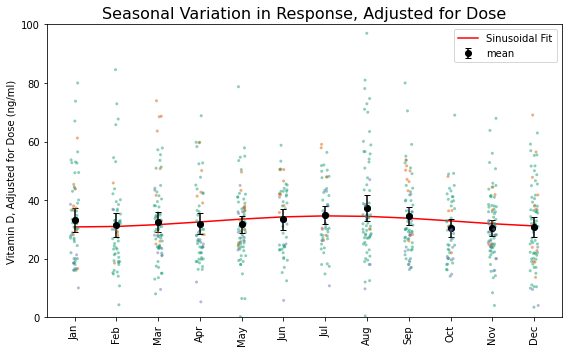

In [2015]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

err = [1.96*(df.groupby('month_twist').result_resid.sem()).values,
 1.96*(df.groupby('month_twist').result_resid.sem()).values]

plt.scatter(x = df.groupby('month_twist').result_resid.mean().index - 1, y = df.groupby('month_twist').result_resid.mean() )
plt.errorbar(df.groupby('month_twist').result_resid.mean().index - 1, df.groupby('month_twist').result_resid.mean(), yerr=err,
             fmt="o", color='black', label='mean', capsize=3)


ii = 0
for pp in set(df.dataset):
    df_dd = df[df.dataset==pp].copy()
    #plt.scatter(df_temp.Sample_Type , df_temp['Firmicutes'], s=3, alpha=0.5)
    sns.stripplot(x=df_dd['month_twist'] , y='result_resid', data=df_dd, 
                  order = [1,2,3,4,5,6,7,8,9,10,11,12],
                  s=3, alpha=0.5, color = colors[ii], zorder = 1 + ii, ax=ax)
    ii += 1


df_temp.plot(x = 'month_minus_one_twist', y = 'result_resid_fit', style = 'r-', ax=ax, label = 'Sinusoidal Fit', zorder=0)

labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
labels_pos = [0,1,2,3,4,5,6,7,8,9,10,11]
plt.xticks(labels_pos, labels, rotation='vertical')


plt.legend(loc='upper right')

plt.ylabel('Vitamin D, Adjusted for Dose (ng/ml)')
plt.xlabel('')
plt.title('Seasonal Variation in Response, Adjusted for Dose', fontsize=16)

#ax.set_yscale('log')
plt.ylim([0,100])

plt.tight_layout()
plt.savefig('Seaonal_Var_Response.jpg', dpi=400)

In [459]:
df_temp

,index,month,cos_t,sin_t,dose_fit,month_minus_one,result_fit,correction,result_resid_fit,month_twist,month_minus_one_twist
2,10,3,0.500027,0.866010,72.565350,2,41.853206,-0.468884,31.383671,1,0
3,14,4,0.000046,1.000000,72.871574,3,41.860183,-1.749906,31.346466,2,1
4,23,5,-0.499947,0.866056,70.635267,4,42.230808,-3.499838,32.039740,3,2
5,11,6,-0.865987,0.500067,66.455612,5,42.865781,-5.249813,33.277742,4,3
6,2,7,-1.000000,0.000093,61.452480,6,43.594969,-6.530954,34.728769,5,4
7,6,8,-0.866079,-0.499906,56.966377,7,44.222999,-7.000000,36.004042,6,5
8,5,9,-0.500107,-0.865964,54.199284,8,44.581600,-6.531278,36.761872,7,6
9,3,10,-0.000139,-1.000000,53.892596,9,44.574691,-5.250374,36.799211,8,7
10,7,11,0.499866,-0.866103,56.128487,10,44.204124,-3.500486,36.106055,9,8
11,8,12,0.865940,-0.500147,60.307886,11,43.569185,-1.750468,34.868124,10,9


In [126]:
df.groupby('month').result.std().index

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='month')

In [134]:
pd.DataFrame(df.groupby('month').result.describe())['']

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')

In [138]:
df.groupby('month').result.quantile(0.025)

month
1     16.300
2     16.950
3     13.750
4     18.525
5     15.000
6     19.000
7     18.825
8     18.875
9     19.200
10    17.325
11    18.000
12    18.700
Name: result, dtype: float64